# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [1]:
# Import warnings


In [2]:
# Import the libraries you will be using for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.0.2
pandas version: 2.2.2
matplotlib version: 3.10.0
seaborn version: 0.13.2


How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [4]:
# Try loading one file

df = pd.read_parquet('/content/2023-1.parquet')
df.info()
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/2023-1.parquet'

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

In [ ]:
# Step 1: Import necessary libraries
import pandas as pd

# Step 2: Load one month's file
DF = pd.read_parquet('/content/2023-1.parquet')

# Step 3: Convert pickup datetime to date and hour
DF['pickup_date'] = pd.to_datetime(DF['tpep_pickup_datetime']).dt.date
DF['pickup_hour'] = pd.to_datetime(DF['tpep_pickup_datetime']).dt.hour

# Step 4: Create an empty DataFrame to collect the sampled data
sampled_data = pd.DataFrame()

# Step 5: Loop through each unique date
for date in DF['pickup_date'].unique():
    DF_date = DF[DF['pickup_date'] == date]

    # Loop through each hour in this date
    for hour in DF_date['pickup_hour'].unique():
        hour_data = DF_date[DF_date['pickup_hour'] == hour]

        # Sample 5% of this hour's data
        sample = hour_data.sample(frac=0.05, random_state=42)

        # Append to the main sampled_data DataFrame
        sampled_data = pd.concat([sampled_data, sample])

# Step 6: Check the result
print("Total sampled records:", len(sampled_data))



In [ ]:
sampled_data.pickup_hour.value_counts(ascending=True)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [5]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
  # Take a small percentage of entries from each hour of every date.
  # Iterating through the monthly data:
  #   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
  # Create a single dataframe for the year combining all the monthly data

  # Select the folder having data files
import os


  # Select the folder having data files
os.chdir('/content/drive/My Drive/Data Science - Upgrad/BootCamp/EDA/Project/trip_records')

  # Create a list of all the twelve files to read
file_list = os.listdir()

  # initialise an empty dataframe
df = pd.DataFrame()


  # iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
          # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

          # Reading the current file
        data = pd.read_parquet(file_path)


          # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
          # After completing iteration through each date, we will append this data to the final dataframe.
          #sampled_data = pd.DataFrame()
        data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
        data['date'] = data['tpep_pickup_datetime'].dt.date
        data['hour'] = data['tpep_pickup_datetime'].dt.hour
        sampled_data1 = pd.DataFrame()

          # Loop through dates and then loop through every hour of each date
        for date in data['date'].unique():
            date_data = data[data['date'] == date]
              # Iterate through each hour of the selected date
            for hour in date_data['hour'].unique():
              hour_data = date_data[date_data['hour'] == hour]
               # Sample 5% of the hourly data randomly
              sample1 = hour_data.sample(frac=0.0075, random_state=42)
                  # add data of this hour to the dataframe

          # Concatenate the sampled data of all the dates to a single dataframe
              sampled_data1 = pd.concat([sampled_data1, sample1], ignore_index=True)
          # we initialised this empty DF earlier
        df = pd.concat([df, sampled_data1], ignore_index=True)
    except Exception as e:
          print(f"Error reading file {file_name}: {e}")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284492 entries, 0 to 284491
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               284492 non-null  int64         
 1   tpep_pickup_datetime   284492 non-null  datetime64[us]
 2   tpep_dropoff_datetime  284492 non-null  datetime64[us]
 3   passenger_count        275065 non-null  float64       
 4   trip_distance          284492 non-null  float64       
 5   RatecodeID             275065 non-null  float64       
 6   store_and_fwd_flag     275065 non-null  object        
 7   PULocationID           284492 non-null  int64         
 8   DOLocationID           284492 non-null  int64         
 9   payment_type           284492 non-null  int64         
 10  fare_amount            284492 non-null  float64       
 11  extra                  284492 non-null  float64       
 12  mta_tax                284492 non-null  floa

In [9]:
df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,date,hour,airport_fee
0,2,2023-02-01 00:14:06,2023-02-01 00:19:52,3.0,1.25,1.0,N,234,114,1,...,0.5,6.12,0.0,1.0,19.72,2.5,0.00,2023-02-01,0,NaN
1,1,2023-02-01 00:54:09,2023-02-01 01:13:13,1.0,5.00,1.0,N,48,87,1,...,0.5,0.00,0.0,1.0,28.30,2.5,0.00,2023-02-01,0,NaN
2,2,2023-02-01 00:14:36,2023-02-01 00:59:16,1.0,24.04,1.0,N,114,121,1,...,0.5,6.00,0.0,1.0,102.20,2.5,0.00,2023-02-01,0,NaN
3,1,2023-02-01 00:49:25,2023-02-01 00:53:12,1.0,0.60,1.0,N,246,68,1,...,0.5,1.00,0.0,1.0,11.80,2.5,0.00,2023-02-01,0,NaN
4,1,2023-02-01 00:16:02,2023-02-01 00:22:02,1.0,0.90,1.0,N,114,148,1,...,0.5,2.55,0.0,1.0,15.45,2.5,0.00,2023-02-01,0,NaN
5,2,2023-02-01 00:08:39,2023-02-01 00:10:50,3.0,0.53,1.0,N,263,263,1,...,0.5,1.08,0.0,1.0,11.18,2.5,0.00,2023-02-01,0,NaN
6,1,2023-02-01 00:13:00,2023-02-01 00:20:15,4.0,1.70,1.0,N,48,170,1,...,0.5,3.00,0.0,1.0,18.00,2.5,0.00,2023-02-01,0,NaN
7,1,2023-02-01 00:10:02,2023-02-01 00:20:24,1.0,3.70,1.0,N,79,140,1,...,0.5,6.35,0.0,1.0,27.65,2.5,0.00,2023-02-01,0,NaN
8,2,2023-02-01 00:09:12,2023-02-01 00:25:02,1.0,3.22,1.0,N,211,233,1,...,0.5,5.85,0.0,1.0,29.25,2.5,0.00,2023-02-01,0,NaN
9,2,2023-02-01 00:41:37,2023-02-01 00:57:04,1.0,9.26,1.0,N,138,232,1,...,0.5,9.57,0.0,1.0,57.42,2.5,1.25,2023-02-01,0,NaN


In [10]:
df['hour'].nunique()

24

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [11]:
# Store the df in csv/parquet
df.to_csv('/content/2023_all_months.csv')

In [12]:
# Define the path where you want to save the file in your Google Drive
output_path = '/content/drive/My Drive/Data Science - Upgrad/BootCamp/EDA/Project/sampled_2023_data.csv'

# Save the DataFrame to CSV
df.to_csv(output_path, index=False)


## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [13]:
# Load the new data file
df=pd.read_csv('/content/2023_all_months.csv')



In [14]:
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,date,hour,airport_fee
0,0,2,2023-02-01 00:14:06,2023-02-01 00:19:52,3.0,1.25,1.0,N,234,114,...,0.5,6.12,0.0,1.0,19.72,2.5,0.0,2023-02-01,0,NaN
1,1,1,2023-02-01 00:54:09,2023-02-01 01:13:13,1.0,5.00,1.0,N,48,87,...,0.5,0.00,0.0,1.0,28.30,2.5,0.0,2023-02-01,0,NaN
2,2,2,2023-02-01 00:14:36,2023-02-01 00:59:16,1.0,24.04,1.0,N,114,121,...,0.5,6.00,0.0,1.0,102.20,2.5,0.0,2023-02-01,0,NaN
3,3,1,2023-02-01 00:49:25,2023-02-01 00:53:12,1.0,0.60,1.0,N,246,68,...,0.5,1.00,0.0,1.0,11.80,2.5,0.0,2023-02-01,0,NaN
4,4,1,2023-02-01 00:16:02,2023-02-01 00:22:02,1.0,0.90,1.0,N,114,148,...,0.5,2.55,0.0,1.0,15.45,2.5,0.0,2023-02-01,0,NaN


In [15]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284492 entries, 0 to 284491
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             284492 non-null  int64  
 1   VendorID               284492 non-null  int64  
 2   tpep_pickup_datetime   284492 non-null  object 
 3   tpep_dropoff_datetime  284492 non-null  object 
 4   passenger_count        275065 non-null  float64
 5   trip_distance          284492 non-null  float64
 6   RatecodeID             275065 non-null  float64
 7   store_and_fwd_flag     275065 non-null  object 
 8   PULocationID           284492 non-null  int64  
 9   DOLocationID           284492 non-null  int64  
 10  payment_type           284492 non-null  int64  
 11  fare_amount            284492 non-null  float64
 12  extra                  284492 non-null  float64
 13  mta_tax                284492 non-null  float64
 14  tip_amount             284492 non-nu

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [16]:
# Fix the index and drop any columns that are not needed
df1 = df.drop(columns=['Unnamed: 0'])



In [17]:
df1.reset_index(drop=True, inplace=True)

In [18]:
df1.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,date,hour,airport_fee
0,2,2023-02-01 00:14:06,2023-02-01 00:19:52,3.0,1.25,1.0,N,234,114,1,...,0.5,6.12,0.0,1.0,19.72,2.5,0.00,2023-02-01,0,NaN
1,1,2023-02-01 00:54:09,2023-02-01 01:13:13,1.0,5.00,1.0,N,48,87,1,...,0.5,0.00,0.0,1.0,28.30,2.5,0.00,2023-02-01,0,NaN
2,2,2023-02-01 00:14:36,2023-02-01 00:59:16,1.0,24.04,1.0,N,114,121,1,...,0.5,6.00,0.0,1.0,102.20,2.5,0.00,2023-02-01,0,NaN
3,1,2023-02-01 00:49:25,2023-02-01 00:53:12,1.0,0.60,1.0,N,246,68,1,...,0.5,1.00,0.0,1.0,11.80,2.5,0.00,2023-02-01,0,NaN
4,1,2023-02-01 00:16:02,2023-02-01 00:22:02,1.0,0.90,1.0,N,114,148,1,...,0.5,2.55,0.0,1.0,15.45,2.5,0.00,2023-02-01,0,NaN
5,2,2023-02-01 00:08:39,2023-02-01 00:10:50,3.0,0.53,1.0,N,263,263,1,...,0.5,1.08,0.0,1.0,11.18,2.5,0.00,2023-02-01,0,NaN
6,1,2023-02-01 00:13:00,2023-02-01 00:20:15,4.0,1.70,1.0,N,48,170,1,...,0.5,3.00,0.0,1.0,18.00,2.5,0.00,2023-02-01,0,NaN
7,1,2023-02-01 00:10:02,2023-02-01 00:20:24,1.0,3.70,1.0,N,79,140,1,...,0.5,6.35,0.0,1.0,27.65,2.5,0.00,2023-02-01,0,NaN
8,2,2023-02-01 00:09:12,2023-02-01 00:25:02,1.0,3.22,1.0,N,211,233,1,...,0.5,5.85,0.0,1.0,29.25,2.5,0.00,2023-02-01,0,NaN
9,2,2023-02-01 00:41:37,2023-02-01 00:57:04,1.0,9.26,1.0,N,138,232,1,...,0.5,9.57,0.0,1.0,57.42,2.5,1.25,2023-02-01,0,NaN


**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [19]:
# Combine the two airport fee columns
df1['airport_fee'] = df1['Airport_fee'].fillna(df1['airport_fee'])
# Drop the old 'Airport_fee' column
df1.drop(columns=['Airport_fee'], inplace=True)
df1.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,date,hour,airport_fee
0,2,2023-02-01 00:14:06,2023-02-01 00:19:52,3.0,1.25,1.0,N,234,114,1,...,1.0,0.5,6.12,0.0,1.0,19.72,2.5,2023-02-01,0,0.00
1,1,2023-02-01 00:54:09,2023-02-01 01:13:13,1.0,5.00,1.0,N,48,87,1,...,3.5,0.5,0.00,0.0,1.0,28.30,2.5,2023-02-01,0,0.00
2,2,2023-02-01 00:14:36,2023-02-01 00:59:16,1.0,24.04,1.0,N,114,121,1,...,1.0,0.5,6.00,0.0,1.0,102.20,2.5,2023-02-01,0,0.00
3,1,2023-02-01 00:49:25,2023-02-01 00:53:12,1.0,0.60,1.0,N,246,68,1,...,3.5,0.5,1.00,0.0,1.0,11.80,2.5,2023-02-01,0,0.00
4,1,2023-02-01 00:16:02,2023-02-01 00:22:02,1.0,0.90,1.0,N,114,148,1,...,3.5,0.5,2.55,0.0,1.0,15.45,2.5,2023-02-01,0,0.00
5,2,2023-02-01 00:08:39,2023-02-01 00:10:50,3.0,0.53,1.0,N,263,263,1,...,1.0,0.5,1.08,0.0,1.0,11.18,2.5,2023-02-01,0,0.00
6,1,2023-02-01 00:13:00,2023-02-01 00:20:15,4.0,1.70,1.0,N,48,170,1,...,3.5,0.5,3.00,0.0,1.0,18.00,2.5,2023-02-01,0,0.00
7,1,2023-02-01 00:10:02,2023-02-01 00:20:24,1.0,3.70,1.0,N,79,140,1,...,3.5,0.5,6.35,0.0,1.0,27.65,2.5,2023-02-01,0,0.00
8,2,2023-02-01 00:09:12,2023-02-01 00:25:02,1.0,3.22,1.0,N,211,233,1,...,1.0,0.5,5.85,0.0,1.0,29.25,2.5,2023-02-01,0,0.00
9,2,2023-02-01 00:41:37,2023-02-01 00:57:04,1.0,9.26,1.0,N,138,232,1,...,6.0,0.5,9.57,0.0,1.0,57.42,2.5,2023-02-01,0,1.25


**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [20]:
# check where values of fare amount are negative
Negative_Fares=df1[df1['fare_amount']<0]
Negative_Fares.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               0 non-null      int64  
 1   tpep_pickup_datetime   0 non-null      object 
 2   tpep_dropoff_datetime  0 non-null      object 
 3   passenger_count        0 non-null      float64
 4   trip_distance          0 non-null      float64
 5   RatecodeID             0 non-null      float64
 6   store_and_fwd_flag     0 non-null      object 
 7   PULocationID           0 non-null      int64  
 8   DOLocationID           0 non-null      int64  
 9   payment_type           0 non-null      int64  
 10  fare_amount            0 non-null      float64
 11  extra                  0 non-null      float64
 12  mta_tax                0 non-null      float64
 13  tip_amount             0 non-null      float64
 14  tolls_amount           0 non-null      float64
 15  improvement_surcharge  

Did you notice something different in the `RatecodeID` column for above records?

In [22]:
# Analyse RatecodeID for the negative fare amounts
Negative_Fares['RatecodeID'].info()


<class 'pandas.core.series.Series'>
Index: 0 entries
Series name: RatecodeID
Non-Null Count  Dtype  
--------------  -----  
0 non-null      float64
dtypes: float64(1)
memory usage: 0.0 bytes


In [23]:
# Find which columns have negative values
negative_columns = df1.apply(lambda x: (x < 0).any() if x.dtype in ['float64', 'int64'] else False)
negative_columns = negative_columns[negative_columns].index
print("Columns with negative values:", list(negative_columns))



Columns with negative values: ['extra', 'mta_tax', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']


In [24]:
# fix these negative values

columns_to_fix = negative_columns

for column in columns_to_fix:
   df1[column] = df1[column].apply(lambda x: max(0, x) if isinstance(x, (int, float)) else x)

print("Negative values replaced with 0.")


Negative values replaced with 0.


In [25]:

negative_columns = df1.apply(lambda x: (x < 0).any() if x.dtype in ['float64', 'int64'] else False)
negative_columns = negative_columns[negative_columns].index
print("Columns with negative values:", list(negative_columns))


Columns with negative values: []


### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [26]:
df1.isnull().sum()

,0
VendorID,0
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
passenger_count,9427
trip_distance,0
RatecodeID,9427
store_and_fwd_flag,9427
PULocationID,0
DOLocationID,0
payment_type,0


In [27]:
# Find the proportion of missing values in each column
df1.isnull().mean()


,0
VendorID,0.000000
tpep_pickup_datetime,0.000000
tpep_dropoff_datetime,0.000000
passenger_count,0.033136
trip_distance,0.000000
RatecodeID,0.033136
store_and_fwd_flag,0.033136
PULocationID,0.000000
DOLocationID,0.000000
payment_type,0.000000


**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [28]:
# Display the rows with null values
# Impute NaN values in 'passenger_count'
print(df1['passenger_count'].isnull().sum())

9427


In [29]:
df1.shape


(284492, 21)

In [30]:
# % of passenger_count missing values
9427/284492

0.033136256907048356

In [31]:
# as the missing values % is very less , we can drop them.
df2=df1[~df1['passenger_count'].isnull()].copy()
print(df2['passenger_count'].isnull().sum())

0


Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [32]:
# Fix missing values in 'RatecodeID'
print(df1['RatecodeID'].isnull().sum())

9427


In [33]:
df1.shape

(284492, 21)

In [34]:
# % of passenger_count missing values
9427/284492

0.033136256907048356

In [35]:
df2=df1[~df1['RatecodeID'].isnull()].copy()
print(df2['RatecodeID'].isnull().sum())

0


In [36]:
df2.isnull().sum()

,0
VendorID,0
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
passenger_count,0
trip_distance,0
RatecodeID,0
store_and_fwd_flag,0
PULocationID,0
DOLocationID,0
payment_type,0


**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [37]:
# handle null values in congestion_surcharge

df2['congestion_surcharge'].describe()

,congestion_surcharge
count,275065.000000
mean,2.308409
std,0.665035
min,0.000000
25%,2.500000
50%,2.500000
75%,2.500000
max,2.500000


In [38]:
df2['congestion_surcharge'].isnull().sum()

np.int64(0)

In [39]:
df2['congestion_surcharge'].value_counts(normalize=True)

,proportion
congestion_surcharge,
2.5,0.923364
0.0,0.076636


In [40]:
congestion_mode=df2['congestion_surcharge'].mode()
congestion_mode

,congestion_surcharge
0,2.5


In [41]:
df2['congestion_surcharge'].fillna(congestion_mode,inplace=True)
df2['congestion_surcharge'].value_counts(normalize=True)

<ipython-input-41-c24f948f750b>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['congestion_surcharge'].fillna(congestion_mode,inplace=True)


,proportion
congestion_surcharge,
2.5,0.923364
0.0,0.076636


In [42]:
df2['congestion_surcharge'].describe()

,congestion_surcharge
count,275065.000000
mean,2.308409
std,0.665035
min,0.000000
25%,2.500000
50%,2.500000
75%,2.500000
max,2.500000


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [43]:
# Handle any remaining missing values
df2.value_counts()


VendorID  tpep_pickup_datetime  tpep_dropoff_datetime  passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  improvement_surcharge  total_amount  congestion_surcharge  date        hour  airport_fee
2         2023-12-31 23:54:03   2023-12-31 23:56:18    3.0              0.44           1.0         N                   164           164           2             4.4          1.0    0.5      0.00        0.0           1.0                    9.40          2.5                   2023-12-31  23    0.0            1
1         2023-01-01 00:04:34   2023-01-01 00:17:32    1.0              1.60           1.0         N                   125           186           1             12.8         3.5    0.5      3.00        0.0           1.0                    20.80         2.5                   2023-01-01  0     0.0            1
          2023-01-01 00:05:27   2023-01-01 00:09:40    2.0              1.20           1.0         N                   162           141           1             7.9          3.5    0.5      2.55        0.0           1.0                    15.45         2.5                   2023-01-01  0     0.0            1
          2023-01-01 00:13:56   2023-01-01 00:23:05    4.0              0.70           1.0         N                   170           170           1             7.9          3.5    0.5      2.55        0.0           1.0                    15.45         2.5                   2023-01-01  0     0.0            1
          2023-01-01 00:15:25   2023-01-01 00:22:35    2.0              0.90           1.0         N                   148           114           1             7.9          3.5    0.5      1.00        0.0           1.0                    13.90         2.5                   2023-01-01  0     0.0            1
                                                                                                                                                                                                                                                                                                                   ..
          2023-01-01 01:16:47   2023-01-01 01:35:53    2.0              3.30           1.0         N                   186           13            1             19.8         3.5    0.5      4.95        0.0           1.0                    29.75         2.5                   2023-01-01  1     0.0            1
          2023-01-01 01:15:01   2023-01-01 01:21:27    1.0              0.70           1.0         N                   263           140           1             7.2          3.5    0.5      2.45        0.0           1.0                    14.65         2.5                   2023-01-01  1     0.0            1
          2023-01-01 01:07:59   2023-01-01 01:17:11    1.0              1.60           1.0         N                   239           50            1             10.0         3.5    0.5      3.00        0.0           1.0                    18.00         2.5                   2023-01-01  1     0.0            1
          2023-01-01 01:04:52   2023-01-01 01:23:27    2.0              1.50           1.0         N                   164           233           1             14.2         3.5    0.5      3.80        0.0           1.0                    23.00         2.5                   2023-01-01  1     0.0            1
          2023-01-01 00:58:43   2023-01-01 01:06:07    2.0              1.70           1.0         N                   107           229           1             9.3          3.5    0.5      1.00        0.0           1.0                    15.30         2.5                   2023-01-01  0     0.0            1
Name: count, Length: 275065, dtype: int64

In [44]:
df2['fare_amount'].value_counts()

,count
fare_amount,
8.6,12514
9.3,12467
10.0,12427
7.9,12153
10.7,11643
...,...
153.5,1
150.4,1
286.0,1


[link text](https://)### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

# Before we start fixing outliers, let's perform outlier analysis.

In [45]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns

df2.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,hour,airport_fee
count,275065.000000,275065.000000,275065.000000,275065.000000,275065.000000,275065.000000,275065.000000,275065.000000,275065.000000,275065.000000,275065.000000,275065.000000,275065.000000,275065.000000,275065.000000,275065.000000,275065.000000
mean,1.736586,1.367568,3.438980,1.656019,165.412946,164.233530,1.205024,19.729235,1.635849,0.495395,3.572653,0.592060,0.999302,28.846682,2.308409,14.298264,0.142435
std,0.440486,0.890947,4.531756,7.533037,63.751977,69.719466,0.465746,18.321463,1.830368,0.047840,4.068677,2.172312,0.024576,22.917999,0.665035,5.775573,0.463846
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.060000,1.000000,132.000000,114.000000,1.000000,9.300000,0.000000,0.500000,1.000000,0.000000,1.000000,15.960000,2.500000,11.000000,0.000000
50%,2.000000,1.000000,1.790000,1.000000,162.000000,162.000000,1.000000,13.500000,1.000000,0.500000,2.860000,0.000000,1.000000,21.000000,2.500000,15.000000,0.000000
75%,2.000000,1.000000,3.370000,1.000000,234.000000,234.000000,1.000000,21.900000,2.500000,0.500000,4.450000,0.000000,1.000000,30.620000,2.500000,19.000000,0.000000
max,2.000000,9.000000,187.350000,99.000000,265.000000,265.000000,4.000000,910.000000,14.250000,0.800000,150.290000,143.000000,1.000000,911.000000,2.500000,23.000000,1.750000


**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [46]:
# remove passenger_count > 6
df2 = df2[df2['passenger_count'] <= 6]
df2.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,hour,airport_fee
count,275060.000000,275060.000000,275060.000000,275060.000000,275060.000000,275060.000000,275060.000000,275060.000000,275060.000000,275060.000000,275060.000000,275060.000000,275060.000000,275060.000000,275060.000000,275060.000000,275060.000000
mean,1.736581,1.367451,3.438867,1.655959,165.413390,164.233371,1.205028,19.728067,1.635878,0.495399,3.572598,0.591899,0.999302,28.845346,2.308433,14.298375,0.142438
std,0.440488,0.890527,4.531391,7.533092,63.751709,69.718808,0.465749,18.319566,1.830371,0.047822,4.068590,2.171713,0.024576,22.915955,0.664998,5.775502,0.463850
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.060000,1.000000,132.000000,114.000000,1.000000,9.300000,0.000000,0.500000,1.000000,0.000000,1.000000,15.960000,2.500000,11.000000,0.000000
50%,2.000000,1.000000,1.790000,1.000000,162.000000,162.000000,1.000000,13.500000,1.000000,0.500000,2.860000,0.000000,1.000000,21.000000,2.500000,15.000000,0.000000
75%,2.000000,1.000000,3.370000,1.000000,234.000000,234.000000,1.000000,21.900000,2.500000,0.500000,4.450000,0.000000,1.000000,30.620000,2.500000,19.000000,0.000000
max,2.000000,6.000000,187.350000,99.000000,265.000000,265.000000,4.000000,910.000000,14.250000,0.800000,150.290000,143.000000,1.000000,911.000000,2.500000,23.000000,1.750000


In [47]:
# Continue with outlier handling
# Remove rows where trip_distance ≈ 0 but fare_amount > 300
df2 = df2[~((df2['trip_distance'] <= 0.01) & (df2['fare_amount'] > 300))]
df2.describe()


,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,hour,airport_fee
count,275054.000000,275054.000000,275054.000000,275054.000000,275054.000000,275054.000000,275054.000000,275054.000000,275054.000000,275054.000000,275054.000000,275054.000000,275054.000000,275054.000000,275054.000000,275054.000000,275054.000000
mean,1.736579,1.367459,3.438942,1.655886,165.412199,164.232154,1.205011,19.717241,1.635914,0.495410,3.572421,0.591912,0.999302,28.834442,2.308483,14.298334,0.142441
std,0.440490,0.890535,4.531412,7.533158,63.750434,69.717746,0.465716,18.148646,1.830375,0.047767,4.066622,2.171735,0.024577,22.779463,0.664917,5.775499,0.463854
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.060000,1.000000,132.000000,114.000000,1.000000,9.300000,0.000000,0.500000,1.000000,0.000000,1.000000,15.960000,2.500000,11.000000,0.000000
50%,2.000000,1.000000,1.790000,1.000000,162.000000,162.000000,1.000000,13.500000,1.000000,0.500000,2.860000,0.000000,1.000000,21.000000,2.500000,15.000000,0.000000
75%,2.000000,1.000000,3.370000,1.000000,234.000000,234.000000,1.000000,21.900000,2.500000,0.500000,4.450000,0.000000,1.000000,30.620000,2.500000,19.000000,0.000000
max,2.000000,6.000000,187.350000,99.000000,265.000000,265.000000,4.000000,455.200000,14.250000,0.800000,150.290000,143.000000,1.000000,488.700000,2.500000,23.000000,1.750000


In [48]:
# Remove rows where trip_distance and fare_amount are 0 but pickup and dropoff zones are different
df2 = df2[~((df2['trip_distance'] == 0) &
          (df2['fare_amount'] == 0) &
          (df2['PULocationID'] != df2['DOLocationID']))]
df2.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,hour,airport_fee
count,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000
mean,1.736590,1.367443,3.439029,1.655488,165.412464,164.230761,1.204983,19.717743,1.635916,0.495420,3.572512,0.591927,0.999316,28.835108,2.308524,14.298349,0.142426
std,0.440483,0.890496,4.531436,7.530956,63.750627,69.716669,0.465669,18.148604,1.830327,0.047711,4.066634,2.171760,0.024280,22.779363,0.664853,5.775536,0.463830
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.060000,1.000000,132.000000,114.000000,1.000000,9.300000,0.000000,0.500000,1.000000,0.000000,1.000000,15.960000,2.500000,11.000000,0.000000
50%,2.000000,1.000000,1.790000,1.000000,162.000000,162.000000,1.000000,13.500000,1.000000,0.500000,2.860000,0.000000,1.000000,21.000000,2.500000,15.000000,0.000000
75%,2.000000,1.000000,3.370000,1.000000,234.000000,234.000000,1.000000,21.900000,2.500000,0.500000,4.450000,0.000000,1.000000,30.620000,2.500000,19.000000,0.000000
max,2.000000,6.000000,187.350000,99.000000,265.000000,265.000000,4.000000,455.200000,14.250000,0.800000,150.290000,143.000000,1.000000,488.700000,2.500000,23.000000,1.750000


In [49]:
# Remove rows where trip_distance > 250 miles
df2 = df2[df2['trip_distance'] <= 250]
df2.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,hour,airport_fee
count,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000
mean,1.736590,1.367443,3.439029,1.655488,165.412464,164.230761,1.204983,19.717743,1.635916,0.495420,3.572512,0.591927,0.999316,28.835108,2.308524,14.298349,0.142426
std,0.440483,0.890496,4.531436,7.530956,63.750627,69.716669,0.465669,18.148604,1.830327,0.047711,4.066634,2.171760,0.024280,22.779363,0.664853,5.775536,0.463830
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.060000,1.000000,132.000000,114.000000,1.000000,9.300000,0.000000,0.500000,1.000000,0.000000,1.000000,15.960000,2.500000,11.000000,0.000000
50%,2.000000,1.000000,1.790000,1.000000,162.000000,162.000000,1.000000,13.500000,1.000000,0.500000,2.860000,0.000000,1.000000,21.000000,2.500000,15.000000,0.000000
75%,2.000000,1.000000,3.370000,1.000000,234.000000,234.000000,1.000000,21.900000,2.500000,0.500000,4.450000,0.000000,1.000000,30.620000,2.500000,19.000000,0.000000
max,2.000000,6.000000,187.350000,99.000000,265.000000,265.000000,4.000000,455.200000,14.250000,0.800000,150.290000,143.000000,1.000000,488.700000,2.500000,23.000000,1.750000


In [50]:
# Remove rows with payment_type == 0
df2 = df2[df2['payment_type'] != 0]
df2.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,hour,airport_fee
count,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000,275047.000000
mean,1.736590,1.367443,3.439029,1.655488,165.412464,164.230761,1.204983,19.717743,1.635916,0.495420,3.572512,0.591927,0.999316,28.835108,2.308524,14.298349,0.142426
std,0.440483,0.890496,4.531436,7.530956,63.750627,69.716669,0.465669,18.148604,1.830327,0.047711,4.066634,2.171760,0.024280,22.779363,0.664853,5.775536,0.463830
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.060000,1.000000,132.000000,114.000000,1.000000,9.300000,0.000000,0.500000,1.000000,0.000000,1.000000,15.960000,2.500000,11.000000,0.000000
50%,2.000000,1.000000,1.790000,1.000000,162.000000,162.000000,1.000000,13.500000,1.000000,0.500000,2.860000,0.000000,1.000000,21.000000,2.500000,15.000000,0.000000
75%,2.000000,1.000000,3.370000,1.000000,234.000000,234.000000,1.000000,21.900000,2.500000,0.500000,4.450000,0.000000,1.000000,30.620000,2.500000,19.000000,0.000000
max,2.000000,6.000000,187.350000,99.000000,265.000000,265.000000,4.000000,455.200000,14.250000,0.800000,150.290000,143.000000,1.000000,488.700000,2.500000,23.000000,1.750000


In [51]:
df2.shape

(275047, 21)

In [52]:
# Do any columns need standardising?

#Not required

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [53]:
df2.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'date',
 'hour',
 'airport_fee']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

In [55]:
df2.dtypes

,0
VendorID,int64
tpep_pickup_datetime,object
tpep_dropoff_datetime,object
passenger_count,float64
trip_distance,float64
RatecodeID,float64
store_and_fwd_flag,object
PULocationID,int64
DOLocationID,int64
payment_type,int64


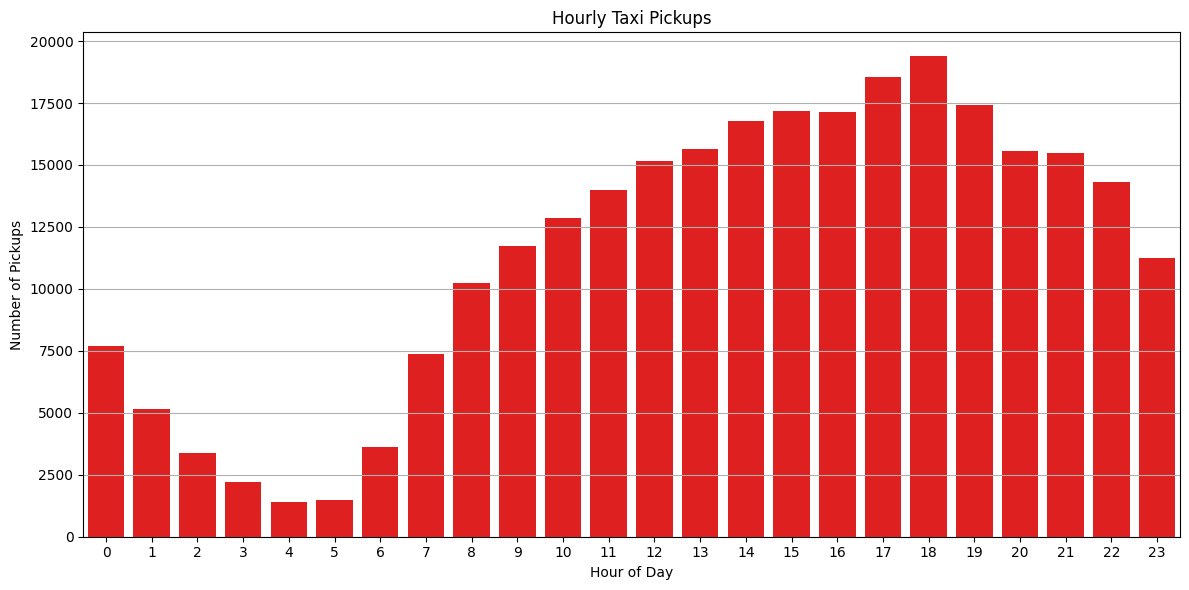

In [140]:
#Find and show the hourly trends in taxi pickups. write code
plt.figure(figsize=(12, 6))
sns.countplot(data=df2, x='hour', color='Red')
plt.title('Hourly Taxi Pickups')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Afternoon to Early Evening (2 PM – 7 PM)
This is the peak demand period, with the highest pickup counts. Hour 18 (6 PM) has the highest activity, followed by 5 PM and 7 PM. This aligns with evening commute, shopping, and dining activity.

Late Morning to Early Afternoon (10 AM – 2 PM)	Moderate pickup volume, potentially linked to business and personal travel.

Early Morning (12 AM – 5 AM)	Significantly lower activity, likely due to fewer passengers on the road. These hours may represent airport runs, late nightlife, or shift changes.

Morning Commute (7 AM – 9 AM)	There's a noticeable pickup in activity, showing the morning rush. However, it's still lower than the evening peak, suggesting more evening ride-hailing in NYC.

day_of_week
Monday       34355
Tuesday      39930
Wednesday    42324
Thursday     43168
Friday       40796
Saturday     39903
Sunday       34571
dtype: int64


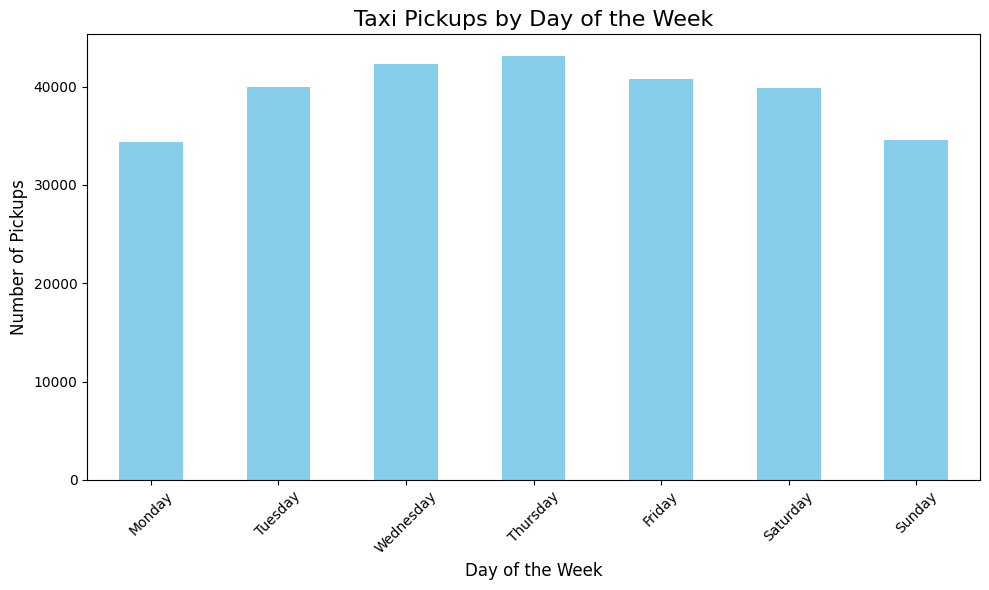

In [138]:
# Find and show the daily trends in taxi pickups (days of the week)

df2['tpep_pickup_datetime']=pd.to_datetime(df2['tpep_pickup_datetime'])
df2['day_of_week'] = df2['tpep_pickup_datetime'].dt.dayofweek
pickup_counts = df2.groupby('day_of_week').size()
pickup_counts.index = pickup_counts.index.map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

print(pickup_counts)
# Plot the daily trends
plt.figure(figsize=(10,6))
pickup_counts.plot.bar(color='skyblue')
plt.title('Taxi Pickups by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Pickups', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Thursday is the busiest day. A lot of people take taxis on this day. Maybe they go out or have late work events.

Wednesday is also very busy. It's in the middle of the week, so many people are moving around the city.

Tuesday, Friday, and Saturday are also busy, but a little less than Wednesday and Thursday.

Monday is the slowest day. Maybe people stay home more or take fewer trips after the weekend.

Sunday is also a bit quiet, probably because it's a rest day and not many people are going to work or events.

The daily trends in taxi pickups (days of the week) indicates that Fridays and Saturdays had the highest number of trips,indicating stronger weekend travel

In [57]:
df2.dtypes

,0
VendorID,int64
tpep_pickup_datetime,datetime64[ns]
tpep_dropoff_datetime,object
passenger_count,float64
trip_distance,float64
RatecodeID,float64
store_and_fwd_flag,object
PULocationID,int64
DOLocationID,int64
payment_type,int64


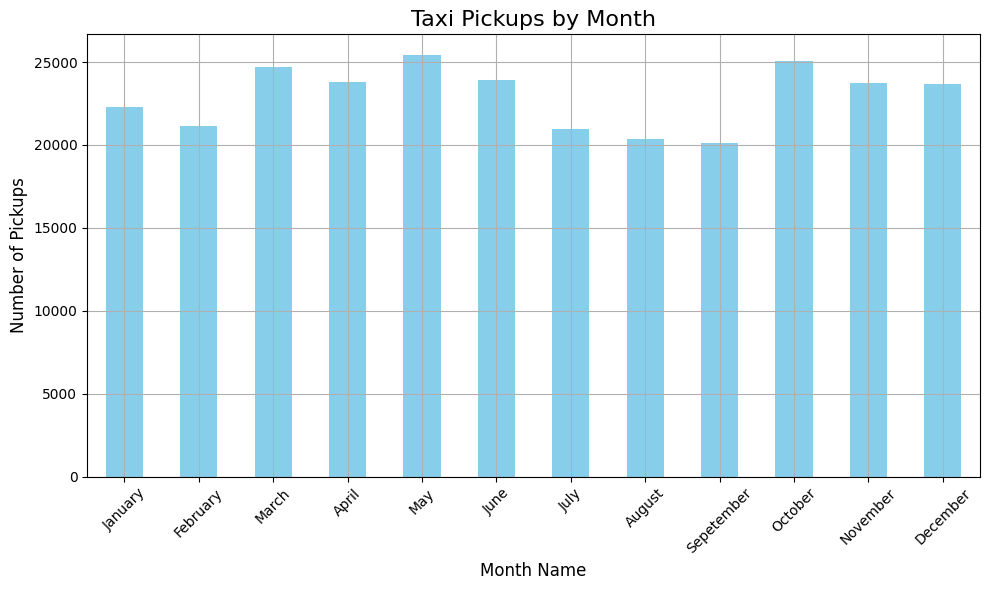

In [145]:
# Show the monthly trends in pickups

df2['Pickupday_of_Month'] = df2['tpep_pickup_datetime'].dt.month
pickup_counts = df2.groupby('Pickupday_of_Month').size()
pickup_counts.index = pickup_counts.index.map({
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July',8:'August',9:'Sepetember',10:'October',11:'November',12:'December'})
# Plot the Montly trends
plt.figure(figsize=(10,6))
pickup_counts.plot.bar(color='skyblue')
plt.title('Taxi Pickups by Month', fontsize=16)
plt.xlabel('Month Name', fontsize=12)
plt.ylabel('Number of Pickups', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


May and October had the most taxi rides. These months seem very busy, maybe because of nice weather or people traveling.

March and April also had a lot of pickups. This could be because the weather is getting better after winter.

Summer months (July, August, September) had fewer rides. Maybe some people are on vacation or using other ways to travel.

January and February had fewer rides too — could be due to cold weather or people staying home more.

December had a good number of rides — maybe due to holidays and people going shopping or visiting family.

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [59]:
# Analyse the above parameters

Financial_Nagative=df2[(df2['fare_amount'] <= 0)| (df2['tip_amount']<= 0)|(df2['total_amount'] <= 0)|(df2['trip_distance'] <= 0)]
Financial_Nagative.shape

(62828, 23)

In [60]:
df2.shape

(275047, 23)

Do you think it is beneficial to create a copy DataFrame leaving out the zero

---

values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [61]:
# Create a df with non zero entries for the selected parameters.
df3 = df2[(df2['fare_amount'] > 0)&(df2['tip_amount'] > 0)&(df2['total_amount'] > 0)&(df2['trip_distance'] > 0)].copy()
df3.shape


(212219, 23)

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

    Pickupday_of_Month  total_amount
0                    1     486594.73
1                    2     463374.75
2                    3     556151.12
3                    4     534263.95
4                    5     591377.77
5                    6     553617.39
6                    7     460902.15
7                    8     452542.95
8                    9     477033.22
9                   10     598645.62
10                  11     554569.20
11                  12     537302.19


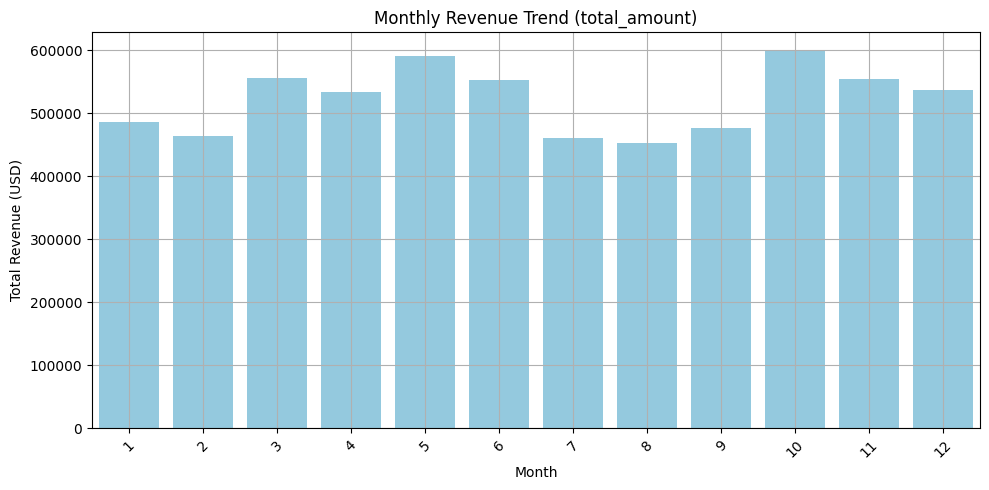

In [147]:
# Group data by month and analyse monthly revenue
monthly_revenue = df3.groupby('Pickupday_of_Month')['total_amount'].sum().reset_index()
monthly_revenue = monthly_revenue.sort_values('Pickupday_of_Month')

# Sort by month
monthly_revenue = monthly_revenue.sort_values('Pickupday_of_Month')

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_revenue['Pickupday_of_Month'], y=monthly_revenue['total_amount'], color='skyblue')
plt.title('Monthly Revenue Trend (total_amount)')
plt.xlabel('Month')
plt.ylabel('Total Revenue (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


October had the highest revenue — about 598,646. That means a lot of people took taxis or took longer/more expensive rides.

May was also very high, followed by March, November, and June.

August and July had the lowest revenue, even though summer is busy with tourists. This might mean rides were shorter or fewer people used taxis.

February and January had less revenue, possibly because of cold weather and fewer people traveling.

In [63]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212219 entries, 0 to 284491
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               212219 non-null  int64         
 1   tpep_pickup_datetime   212219 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  212219 non-null  object        
 3   passenger_count        212219 non-null  float64       
 4   trip_distance          212219 non-null  float64       
 5   RatecodeID             212219 non-null  float64       
 6   store_and_fwd_flag     212219 non-null  object        
 7   PULocationID           212219 non-null  int64         
 8   DOLocationID           212219 non-null  int64         
 9   payment_type           212219 non-null  int64         
 10  fare_amount            212219 non-null  float64       
 11  extra                  212219 non-null  float64       
 12  mta_tax                212219 non-null  float64  

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

<ipython-input-151-3a2e11e55a9f>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quarterly_revenue = df3.groupby('Pickupday_Quarter')['total_amount'].sum().reset_index()


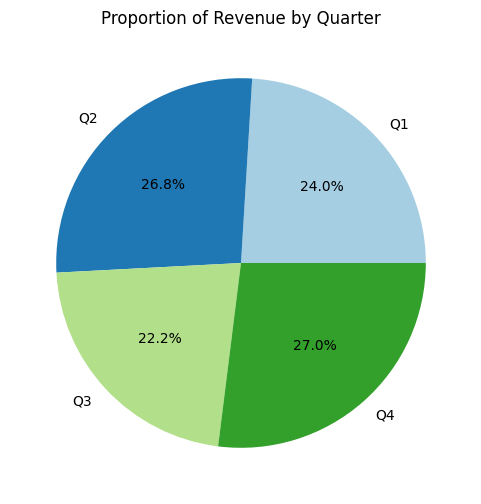

In [151]:
# Calculate proportion of each quarter
df3['Pickupday_Quarter'] = pd.cut(
    df3['Pickupday_of_Month'],
    bins=[0, 3, 6, 9, 12],
    labels=['Q1', 'Q2', 'Q3', 'Q4']
)
quarterly_revenue = df3.groupby('Pickupday_Quarter')['total_amount'].sum().reset_index()
total_revenue = quarterly_revenue['total_amount'].sum()
quarterly_revenue['Revenue_Proportion'] = quarterly_revenue['total_amount'] / total_revenue
plt.figure(figsize=(6, 6))

plt.pie(
    quarterly_revenue['Revenue_Proportion'],
    labels=quarterly_revenue['Pickupday_Quarter'],
    autopct='%1.1f%%',
    colors=plt.cm.Paired.colors
)
plt.title('Proportion of Revenue by Quarter')
plt.show()


Q4 (October to December) had the highest revenue, slightly more than Q2. This could be due to fall events, holidays, and people traveling more.

Q2 (April to June) also had strong revenue, possibly from good weather and spring tourism.

Q1 (January to March) had less revenue, likely due to winter weather and slow travel.

Q3 (July to September) had the lowest revenue overall — maybe fewer rides, vacations, or more competition from other transport options.

In [65]:
df

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,date,hour,airport_fee
0,0,2,2023-02-01 00:14:06,2023-02-01 00:19:52,3.0,1.25,1.0,N,234,114,...,0.5,6.12,0.0,1.0,19.72,2.5,0.0,2023-02-01,0,NaN
1,1,1,2023-02-01 00:54:09,2023-02-01 01:13:13,1.0,5.00,1.0,N,48,87,...,0.5,0.00,0.0,1.0,28.30,2.5,0.0,2023-02-01,0,NaN
2,2,2,2023-02-01 00:14:36,2023-02-01 00:59:16,1.0,24.04,1.0,N,114,121,...,0.5,6.00,0.0,1.0,102.20,2.5,0.0,2023-02-01,0,NaN
3,3,1,2023-02-01 00:49:25,2023-02-01 00:53:12,1.0,0.60,1.0,N,246,68,...,0.5,1.00,0.0,1.0,11.80,2.5,0.0,2023-02-01,0,NaN
4,4,1,2023-02-01 00:16:02,2023-02-01 00:22:02,1.0,0.90,1.0,N,114,148,...,0.5,2.55,0.0,1.0,15.45,2.5,0.0,2023-02-01,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284487,284487,2,2023-08-31 23:53:10,2023-09-01 00:03:54,3.0,1.29,1.0,N,231,148,...,0.5,0.00,0.0,1.0,15.00,2.5,0.0,2023-08-31,23,NaN
284488,284488,2,2023-08-31 23:48:42,2023-09-01 00:12:37,1.0,4.15,1.0,N,161,232,...,0.5,5.94,0.0,1.0,35.64,2.5,0.0,2023-08-31,23,NaN
284489,284489,1,2023-08-31 23:15:46,2023-08-31 23:16:00,1.0,0.00,1.0,N,161,161,...,0.5,0.00,0.0,1.0,8.00,2.5,0.0,2023-08-31,23,NaN
284490,284490,2,2023-08-31 23:10:59,2023-08-31 23:16:11,1.0,0.89,1.0,N,230,142,...,0.5,2.44,0.0,1.0,14.64,2.5,0.0,2023-08-31,23,NaN


**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

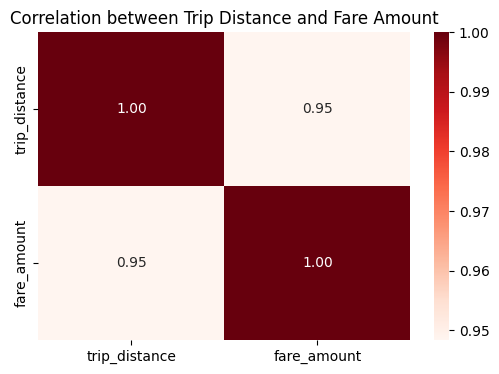

In [66]:
# Show how trip fare is affected by distance

df_filtered = df3[df3['trip_distance'] > 0]
corr = df_filtered[['trip_distance', 'fare_amount']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(data=corr, annot=True, cmap='Reds', fmt=".2f")
plt.title("Correlation between Trip Distance and Fare Amount")
plt.show()

A correlation of 0.95 means that as trip distance increases, the fare amount also increases — almost directly.

Longer rides almost always cost more.





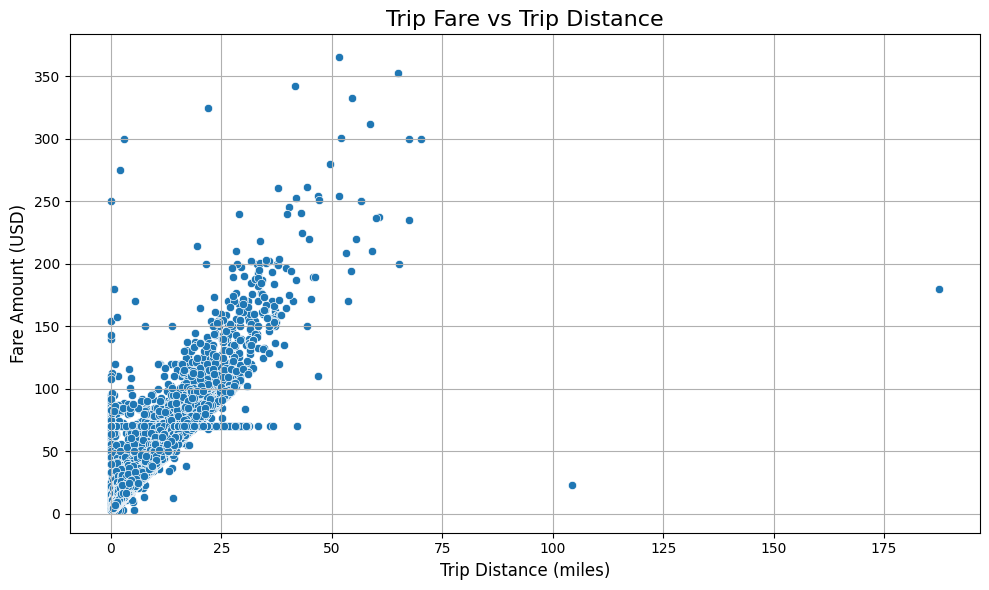

In [67]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='fare_amount', data=df_filtered, )
plt.title('Trip Fare vs Trip Distance', fontsize=16)
plt.xlabel('Trip Distance (miles)', fontsize=12)
plt.ylabel('Fare Amount (USD)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

 trip distance increases, the fare amount also increases — almost directly.

Longer rides almost always cost more.

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [68]:
df3.dtypes

,0
VendorID,int64
tpep_pickup_datetime,datetime64[ns]
tpep_dropoff_datetime,object
passenger_count,float64
trip_distance,float64
RatecodeID,float64
store_and_fwd_flag,object
PULocationID,int64
DOLocationID,int64
payment_type,int64


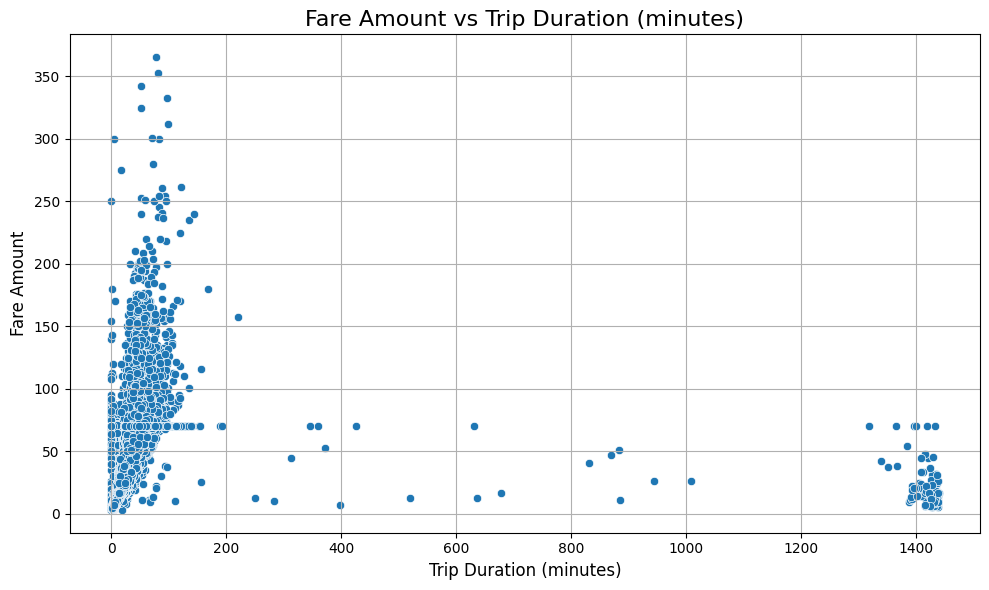

Correlation between fare_amount and passenger_count: 0.3320


In [155]:
# Show relationship between fare and trip duration
df3['tpep_pickup_datetime'] = pd.to_datetime(df3['tpep_pickup_datetime'], errors='coerce')
df3['tpep_dropoff_datetime'] = pd.to_datetime(df3['tpep_dropoff_datetime'], errors='coerce')
df3['trip_duration'] = (df3['tpep_dropoff_datetime'] - df3['tpep_pickup_datetime']).dt.total_seconds() / 60
# Filter out any invalid durations or zero-distance trips
df_corr = df3[
    (df3['trip_duration'] > 0) &
    (df3['trip_distance'] > 0) &
    (df3['fare_amount'] > 0) &
    (df3['passenger_count'] > 0)
].copy()
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_duration', y='fare_amount', data=df_corr)
plt.title('Fare Amount vs Trip Duration (minutes)', fontsize=16)
plt.xlabel('Trip Duration (minutes)', fontsize=12)
plt.ylabel('Fare Amount', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation
corr1 = df_corr[['trip_duration', 'fare_amount']].corr().iloc[0, 1]
print(f"Correlation between fare_amount and passenger_count: {corr1:.4f}")

The plot shows that most trips last less than 150 minutes, and fares mostly range from 10 to 150

Some trips have very long durations (over 1000 minutes) but low fares — these are likely errors or special cases (e.g., parked or waiting time not billed).

There is a general upward pattern, especially for trips under 200 minutes — meaning that as duration increases, fare tends to increase too.
A correlation of 0.3320 between fare_amount and trip_duration means there is a positive but weak relationship — fares do go up as duration increases, but not as strongly as they do with distance.



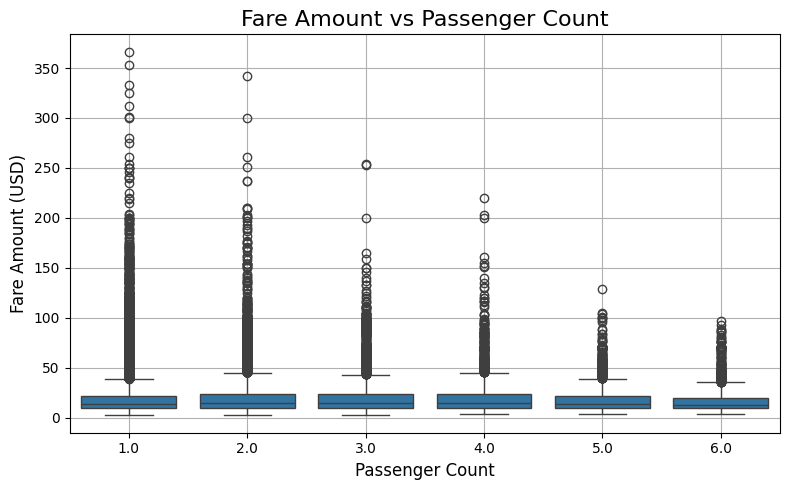

Correlation between fare_amount and passenger_count: 0.0375


In [70]:
# Show relationship between fare and number of passengers
plt.figure(figsize=(8, 5))
sns.boxplot(x='passenger_count', y='fare_amount', data=df_corr)
plt.title('Fare Amount vs Passenger Count', fontsize=16)
plt.xlabel('Passenger Count', fontsize=12)
plt.ylabel('Fare Amount (USD)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation
corr2 = df_corr[['passenger_count', 'fare_amount']].corr().iloc[0, 1]
print(f"Correlation between fare_amount and passenger_count: {corr2:.4f}")


This is a weak positive correlation.

So, adding more passengers might increase the fare slightly (e.g., group airport trips), but not consistently.
Fare is not strongly affected by how many passengers are in the taxi.
This suggests passenger count is not a major factor in fare pricing for most trips.




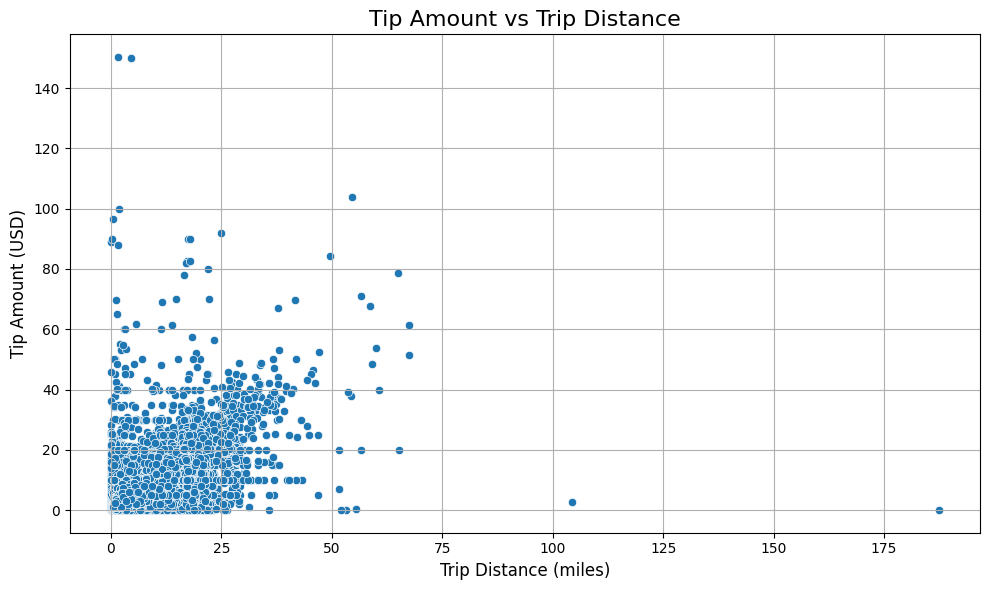

Correlation between tip_amount and trip_distance: 0.7953


In [71]:
# Show relationship between tip and trip distance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='tip_amount', data=df_corr)
plt.title('Tip Amount vs Trip Distance', fontsize=16)
plt.xlabel('Trip Distance (miles)', fontsize=12)
plt.ylabel('Tip Amount (USD)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation
corr3 = df_corr[['trip_distance', 'tip_amount']].corr().iloc[0, 1]
print(f"Correlation between tip_amount and trip_distance: {corr3:.4f}")


This shows that most trips are under 25 miles and tips are mostly under 40.
We can see a positive trend as the trip distance increases, the tip amount also tends to increase.
Some outliers show very high tips (over 100), but these are rare.
This is a strong positive correlation.

It means that longer trips often receive higher tips — maybe because:

They cost more overall







**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

<Axes: xlabel='payment_type_label'>

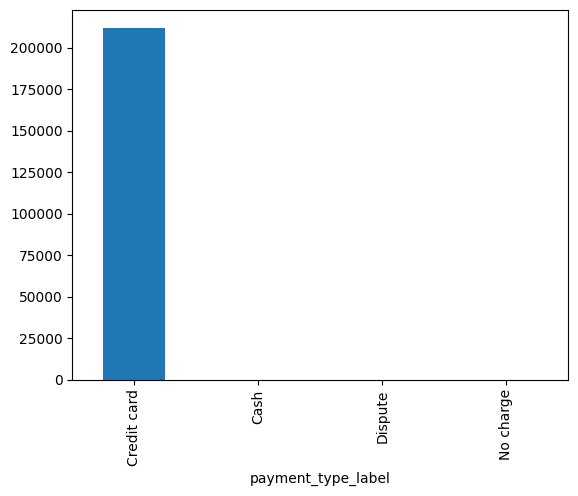

In [72]:
# Analyse the distribution of different payment types (payment_type).
payment_map = {
    1: "Credit card",
    2: "Cash",
    3: "No charge",
    4: "Dispute"}

df3['payment_type_label'] = df["payment_type"].map(payment_map)
df3['payment_type_label'].value_counts().plot.bar()


- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



Credit cards are clearly the most preferred payment method in NYC taxis.

This might be due to:

More people using apps or card terminals.

Business travelers needing receipts.

Convenience and safety over carrying cash.

In [73]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212219 entries, 0 to 284491
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               212219 non-null  int64         
 1   tpep_pickup_datetime   212219 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  212219 non-null  datetime64[ns]
 3   passenger_count        212219 non-null  float64       
 4   trip_distance          212219 non-null  float64       
 5   RatecodeID             212219 non-null  float64       
 6   store_and_fwd_flag     212219 non-null  object        
 7   PULocationID           212219 non-null  int64         
 8   DOLocationID           212219 non-null  int64         
 9   payment_type           212219 non-null  int64         
 10  fare_amount            212219 non-null  float64       
 11  extra                  212219 non-null  float64       
 12  mta_tax                212219 non-null  float64  

##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [74]:
!pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [75]:
import geopandas as gpd


In [76]:

# Read the shapefile using geopandas
import os
os.chdir('/content/drive/My Drive/Data Science - Upgrad/BootCamp/EDA/Project/taxi_zones/')
zones = gpd.read_file('taxi_zones.shp')
zones.head()




,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

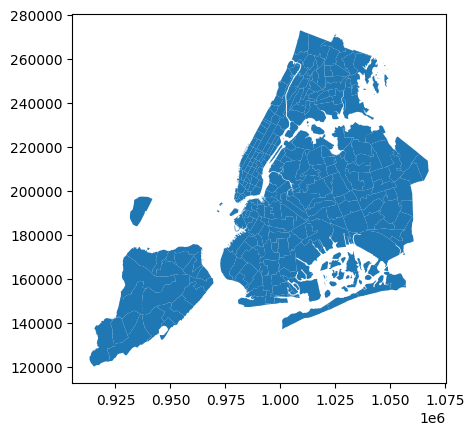

In [77]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.

---





**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [78]:
df3.shape

(212219, 26)

In [79]:
# Merge zones and trip records using locationID and PULocationID
df4=df3.merge(zones,left_on='PULocationID',right_on='LocationID',how='left')
df4.info()
df4.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212223 entries, 0 to 212222
Data columns (total 33 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               212223 non-null  int64         
 1   tpep_pickup_datetime   212223 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  212223 non-null  datetime64[ns]
 3   passenger_count        212223 non-null  float64       
 4   trip_distance          212223 non-null  float64       
 5   RatecodeID             212223 non-null  float64       
 6   store_and_fwd_flag     212223 non-null  object        
 7   PULocationID           212223 non-null  int64         
 8   DOLocationID           212223 non-null  int64         
 9   payment_type           212223 non-null  int64         
 10  fare_amount            212223 non-null  float64       
 11  extra                  212223 non-null  float64       
 12  mta_tax                212223 non-null  floa

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,Pickupday_Quarter,trip_duration,payment_type_label,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,2,2023-02-01 00:14:06,2023-02-01 00:19:52,3.0,1.25,1.0,N,234,114,1,...,Q1,5.766667,Credit card,234.0,0.036072,0.000073,Union Sq,234.0,Manhattan,"POLYGON ((987029.847 207022.299, 987048.27 206..."
1,2,2023-02-01 00:14:36,2023-02-01 00:59:16,1.0,24.04,1.0,N,114,121,1,...,Q1,44.666667,Credit card,114.0,0.031727,0.000047,Greenwich Village South,114.0,Manhattan,"POLYGON ((986306.712 203122.786, 986300.242 20..."
2,1,2023-02-01 00:49:25,2023-02-01 00:53:12,1.0,0.60,1.0,N,246,68,1,...,Q1,3.783333,Credit card,246.0,0.069467,0.000281,West Chelsea/Hudson Yards,246.0,Manhattan,"POLYGON ((983031.177 217138.506, 983640.32 216..."
3,1,2023-02-01 00:16:02,2023-02-01 00:22:02,1.0,0.90,1.0,N,114,148,1,...,Q1,6.000000,Credit card,114.0,0.031727,0.000047,Greenwich Village South,114.0,Manhattan,"POLYGON ((986306.712 203122.786, 986300.242 20..."
4,2,2023-02-01 00:08:39,2023-02-01 00:10:50,3.0,0.53,1.0,N,263,263,1,...,Q1,2.183333,Credit card,263.0,0.037017,0.000066,Yorkville West,263.0,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22..."


In [80]:
df4.isnull().sum()

,0
VendorID,0
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
passenger_count,0
trip_distance,0
RatecodeID,0
store_and_fwd_flag,0
PULocationID,0
DOLocationID,0
payment_type,0


In [81]:
df4.shape

(212223, 33)

In [82]:
1812/212223

#"Approximately 0.85% of trips had pickup location IDs that could not be matched to known taxi zones. These were retained for completeness but excluded from spatial analysis.

0.008538188603497265

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [83]:
# Group data by location and calculate the number of trips

total_trips = df3.groupby('PULocationID').size().reset_index(name='trip_count')
total_trips

,PULocationID,trip_count
0,1,4
1,4,207
2,6,1
3,7,33
4,9,1
...,...,...
151,261,1052
152,262,2856
153,263,4169
154,264,1786


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [84]:
# Merge trip counts back to the zones GeoDataFrame

zones_trips = zones.merge(total_trips, left_on='LocationID', right_on='PULocationID', how='left')

# Check the result
zones_trips.head()



,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,trip_count
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1.0,4.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",NaN,NaN
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",NaN,NaN
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4.0,207.0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",NaN,NaN


In [85]:
zones_trips[['LocationID', 'zone', 'trip_count']].head()



,LocationID,zone,trip_count
0,1,Newark Airport,4.0
1,2,Jamaica Bay,NaN
2,3,Allerton/Pelham Gardens,NaN
3,4,Alphabet City,207.0
4,5,Arden Heights,NaN


The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

zone
Upper East Side South           10559.0
Midtown Center                  10088.0
JFK Airport                      9638.0
Upper East Side North            9543.0
Midtown East                     8041.0
LaGuardia Airport                7642.0
Lincoln Square East              7244.0
Penn Station/Madison Sq West     7181.0
Times Sq/Theatre District        6674.0
Murray Hill                      6442.0
Name: trip_count, dtype: float64


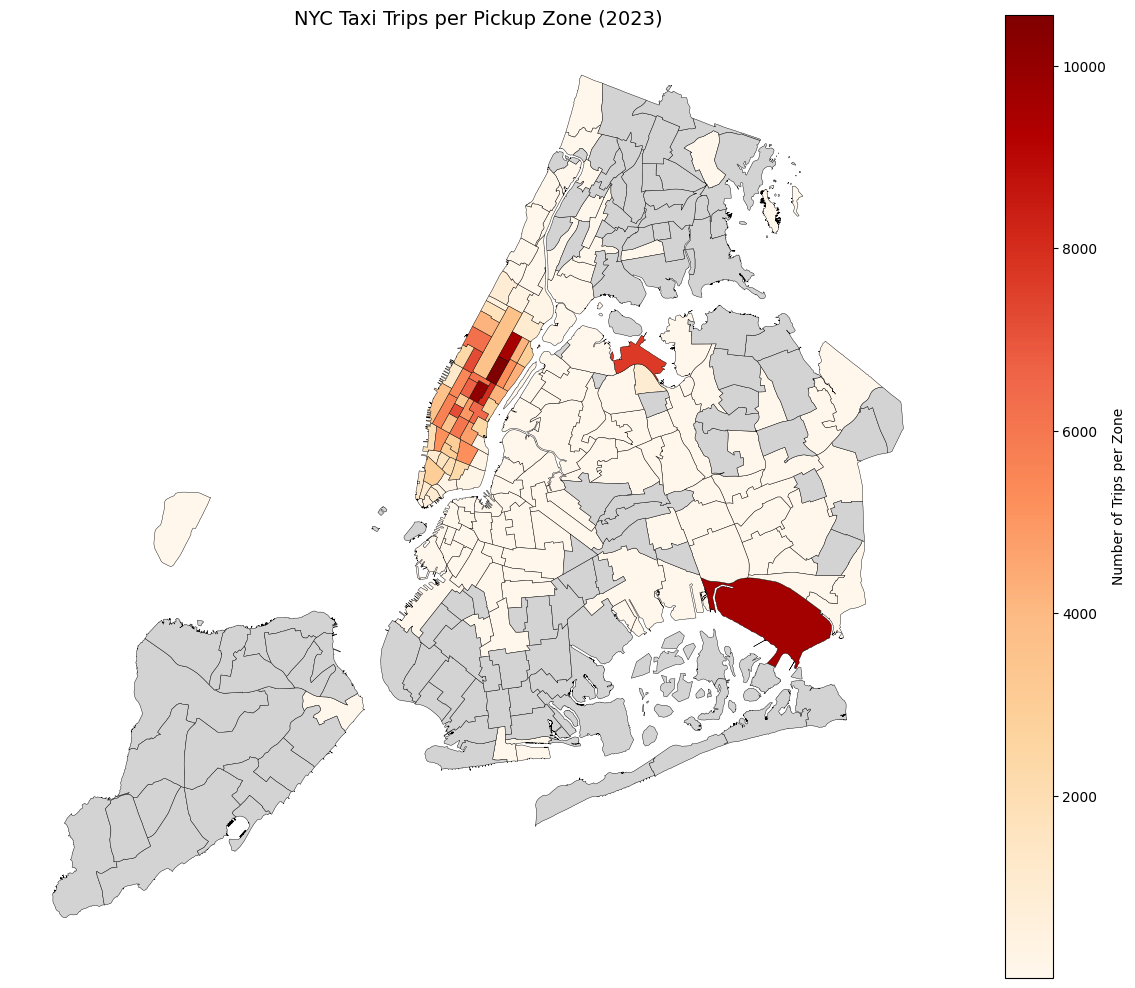

In [162]:
# Define figure and axis

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the map and display it
print(zones_trips.groupby('zone')['trip_count'].sum().sort_values(ascending=False).head(10))
zones_trips.plot(
    column='trip_count',
    ax=ax,
    legend=True,
    cmap='OrRd',
    legend_kwds={
        'label': "Number of Trips per Zone",
        'orientation': "vertical"
    },
    missing_kwds={
        "color": "lightgrey",
        "label": "No trips recorded"
    },
    edgecolor='black',
    linewidth=0.3
)

ax.set_title('NYC Taxi Trips per Pickup Zone (2023)', fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

Upper East Side (both North and South) is very busy — May be lots of people live or work there, and many seem to take taxis from that area.

Midtown areas (Center and East) are also very active —May be this makes sense because they are full of offices, hotels, and shops.

Airports (JFK and LaGuardia) are big pickup points — May be likely from people arriving in the city and needing taxis to their destinations.

Penn Station and Times Square are important spots too — May be full of tourists, commuters, and city visitors.

Murray Hill and Lincoln Square East also show strong activity — May be these are popular residential and nightlife areas.




In [87]:
# can you try displaying the zones DF sorted by the number of trips?

zones_sorted = zones_trips.sort_values(by='trip_count', ascending=False)
zones_sorted

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,trip_count
236,237,0.042213,0.000096,Upper East Side South,237,Manhattan,"POLYGON ((993633.442 216961.016, 993507.232 21...",237.0,10559.0
160,161,0.035804,0.000072,Midtown Center,161,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",161.0,10088.0
131,132,0.245479,0.002038,JFK Airport,132,Queens,"MULTIPOLYGON (((1032791.001 181085.006, 103283...",132.0,9638.0
235,236,0.044252,0.000103,Upper East Side North,236,Manhattan,"POLYGON ((995940.048 221122.92, 995812.322 220...",236.0,9543.0
161,162,0.035270,0.000048,Midtown East,162,Manhattan,"POLYGON ((992224.354 214415.293, 992096.999 21...",162.0,8041.0
...,...,...,...,...,...,...,...,...,...
250,251,0.137711,0.000626,Westerleigh,251,Staten Island,"POLYGON ((947868.004 169247.734, 948000.981 16...",NaN,NaN
251,252,0.158004,0.001025,Whitestone,252,Queens,"POLYGON ((1033946.683 231157.996, 1033973.166 ...",NaN,NaN
253,254,0.085886,0.000360,Williamsbridge/Olinville,254,Bronx,"POLYGON ((1025214.477 259577.301, 1025348.099 ...",NaN,NaN
256,257,0.058669,0.000139,Windsor Terrace,257,Brooklyn,"POLYGON ((989842.548 179997.856, 989842.643 17...",NaN,NaN


*Here* we have completed the temporal, financial and geographical analysis the trip records.

**Compile your findings from general analysis below:**

> Add blockquote



You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


**Busiest hours, days and months:**
Busiest Hours: Most pickups happen between 2 PM to 7 PM, with a clear peak at 6 PM. Early mornings (0–5 AM) have the lowest activity.

Busiest Days: Thursday and Wednesday are the busiest days, followed closely by Friday. Sunday and Monday are the least busy.

Busiest Months: May and October had the highest number of trips, while August and September were among the lowest.
**Trends in revenue collected**

 Highest in October, followed by May and March. July and August collected the least revenue.

**Trends in Quarterly Revenue **

Q4 (Oct–Dec) and Q2 (Apr–Jun) had the highest revenue (~27% each of the total).

Q3 (Jul–Sep) had the lowest revenue (~22%), possibly due to summer vacations.

**How fare depends on trip distance, trip duration and passenger counts**

Trip distance has a strong effect on fare (correlation ≈ 0.95) — longer trips = higher fare.

**How tip amount depends on trip distance**
Trip duration has a weak effect on fare (correlation ≈ 0.33) — longer time doesn't always mean higher fare.

Passenger count has little to no effect on fare.Tip amount increases with trip distance (correlation ≈ 0.79).

Passengers tend to tip more on longer rides — possibly airport or out-of-city trips.

**Busiest Pickup Zones**

Upper East Side South and Midtown Center top the list.

JFK and LaGuardia Airports are also major pickup points.

Other high-demand zones: Times Square, Penn Station, Murray Hill, and Lincoln Square.

Many outer zones had very few or zero pickups, especially in the Bronx and Staten Island.
Focus taxi availability in central Manhattan and airport zones, especially during weekday afternoons and evenings.



#### **3.2** Detailed EDA: Insights and Strategies

> Add blockquote


<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or

---

inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [88]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212223 entries, 0 to 212222
Data columns (total 33 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               212223 non-null  int64         
 1   tpep_pickup_datetime   212223 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  212223 non-null  datetime64[ns]
 3   passenger_count        212223 non-null  float64       
 4   trip_distance          212223 non-null  float64       
 5   RatecodeID             212223 non-null  float64       
 6   store_and_fwd_flag     212223 non-null  object        
 7   PULocationID           212223 non-null  int64         
 8   DOLocationID           212223 non-null  int64         
 9   payment_type           212223 non-null  int64         
 10  fare_amount            212223 non-null  float64       
 11  extra                  212223 non-null  float64       
 12  mta_tax                212223 non-null  floa

In [89]:
# Find routes which have the slowest speeds at different times of the day

# Filter for valid trips with distance > 0 and duration > 0
Valid_trips = df4[(df4['trip_distance'] > 0) & (df4['trip_duration'] > 0)].copy()  # Use .copy() to avoid warnings

# Create a new column for route (e.g., 'PU_DO')
Valid_trips['route'] = Valid_trips['PULocationID'].astype(str) + '_' + Valid_trips['DOLocationID'].astype(str)

# Group by route and hour to calculate average speed
route_speed = Valid_trips.groupby(['route', 'hour']).agg({
    'trip_distance': 'mean',
    'trip_duration': 'mean'
}).reset_index()

# Calculate average speed (speed in miles/hour)
route_speed['avg_speed'] = route_speed['trip_distance'] / (route_speed['trip_duration'] / 60)

# Find slowest routes by sorting and taking the top 10 slowest routes
slow_routes = route_speed.sort_values(by='avg_speed').head(10)

# Reset index for cleaner output
slow_routes = slow_routes.reset_index(drop=True)

# Display the result
slow_routes



,route,hour,trip_distance,trip_duration,avg_speed
0,113_113,13,0.39,1426.733333,0.016401
1,209_232,13,1.04,1431.883333,0.043579
2,164_100,21,0.79,698.833333,0.067827
3,41_41,16,0.67,480.200000,0.083715
4,209_25,22,2.52,1425.650000,0.106057
5,234_256,18,3.22,1425.250000,0.135555
6,163_87,15,0.09,38.550000,0.140078
7,113_181,19,0.09,35.250000,0.153191
8,229_41,17,4.16,1428.083333,0.174780
9,229_145,16,2.39,703.366667,0.203877


How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

hour
0     121080.0
1      80520.0
2      51120.0
3      32080.0
4      18020.0
5      19120.0
6      52460.0
7     113560.0
8     161460.0
9     180420.0
10    191220.0
11    207380.0
12    224500.0
13    231500.0
14    251500.0
15    257340.0
16    259520.0
17    291820.0
18    309120.0
19    277500.0
20    249920.0
21    252240.0
22    232620.0
23    178440.0
Name: count, dtype: float64


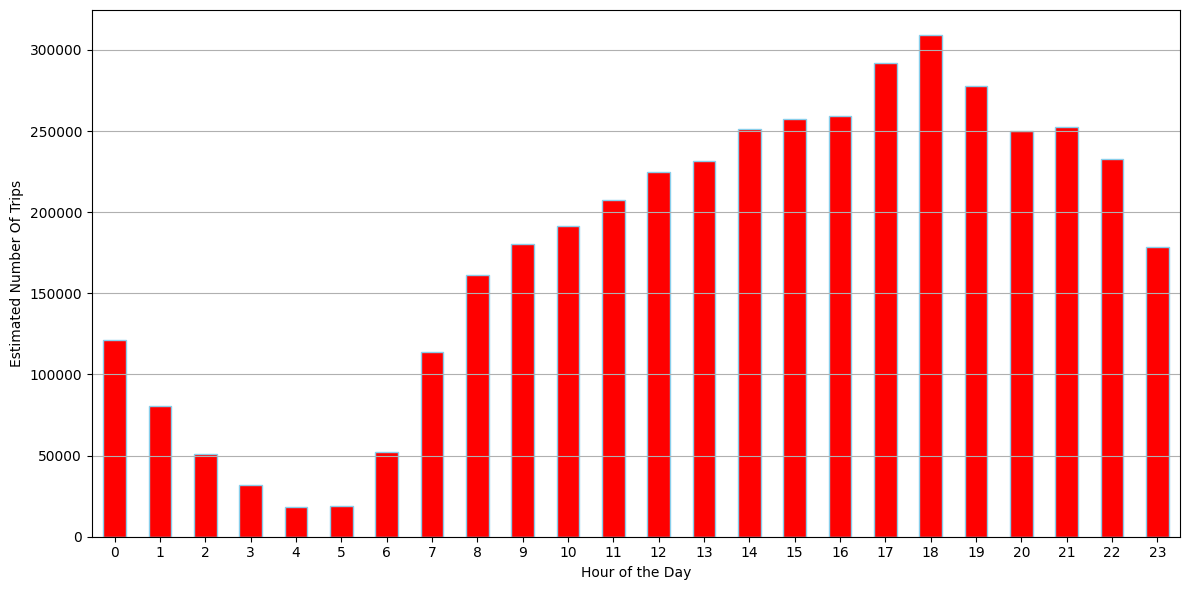

The busiest hour is 18:00 with approximately 309,120 trips.


In [163]:
# Visualise the number of trips per hour and find the busiest hour
hourly_trips=df4['hour'].value_counts().sort_index()
sample=0.05
hourly_trip_sample=hourly_trips/sample
plt.figure(figsize=(12,6))
print(hourly_trip_sample)
hourly_trip_sample.plot(kind='bar',color='red',edgecolor='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Estimated Number Of Trips')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#Busiest hour
busiest_hour=hourly_trip_sample.idxmax()
busiest_hour_count=int(hourly_trip_sample.max())
print(f"The busiest hour is {busiest_hour}:00 with approximately {busiest_hour_count:,} trips.")


The busiest hour is 6 PM — this is likely due to people leaving work, going out, or catching evening events.

Rush hour traffic starts building around 3 PM and continues strong until 8 PM.

The quietest time is early morning, especially between 3 AM to 6 AM.

There is also a morning rise starting at 7 AM, with steady growth until midday.

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [91]:
# Scale up the number of trips
sample=0.05
hourly_trip_sample=hourly_trips/sample

# Fill in the value of your sampling fraction and use that to scale up the numbers
five_Busienst_hours=hourly_trip_sample.sort_values(ascending=False).head()
five_Busienst_hours


,count
hour,
18,309120.0
17,291820.0
19,277500.0
16,259520.0
15,257340.0


**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

In [92]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212223 entries, 0 to 212222
Data columns (total 33 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               212223 non-null  int64         
 1   tpep_pickup_datetime   212223 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  212223 non-null  datetime64[ns]
 3   passenger_count        212223 non-null  float64       
 4   trip_distance          212223 non-null  float64       
 5   RatecodeID             212223 non-null  float64       
 6   store_and_fwd_flag     212223 non-null  object        
 7   PULocationID           212223 non-null  int64         
 8   DOLocationID           212223 non-null  int64         
 9   payment_type           212223 non-null  int64         
 10  fare_amount            212223 non-null  float64       
 11  extra                  212223 non-null  float64       
 12  mta_tax                212223 non-null  floa

In [93]:
# Compare traffic trends for the week days and weekends

df4['Pickupday_type']=df4['day_of_week'].apply(lambda x:'Weekend' if x>=5 else 'Weekday')
pivot_df = hourly_counts.pivot(index='hour', columns='day_type', values='trip_count').fillna(0)


NameError: name 'hourly_counts' is not defined

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

In [94]:
# Scale up the number of trips
sample=0.05
hourly_trip_sample=hourly_trips/sample

# Fill in the value of your sampling fraction and use that to scale up the numbers
five_quiet_hours=hourly_trip_sample.sort_values(ascending=True).head()
five_quiet_hours

,count
hour,
4,18020.0
5,19120.0
3,32080.0
2,51120.0
6,52460.0


Busiest Hours:

Likely to be  late afternoon/evening (return commute) meanig 18 to 15 PM.

Suggests peak demand around after office hours and after events or nightlife.

Quieter Hours:

Very early morning (e.g. 4 to 6 AM) often sees minimal traffic.

These off-peak hours may still be relevant for airport transfers or night shift workers.

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

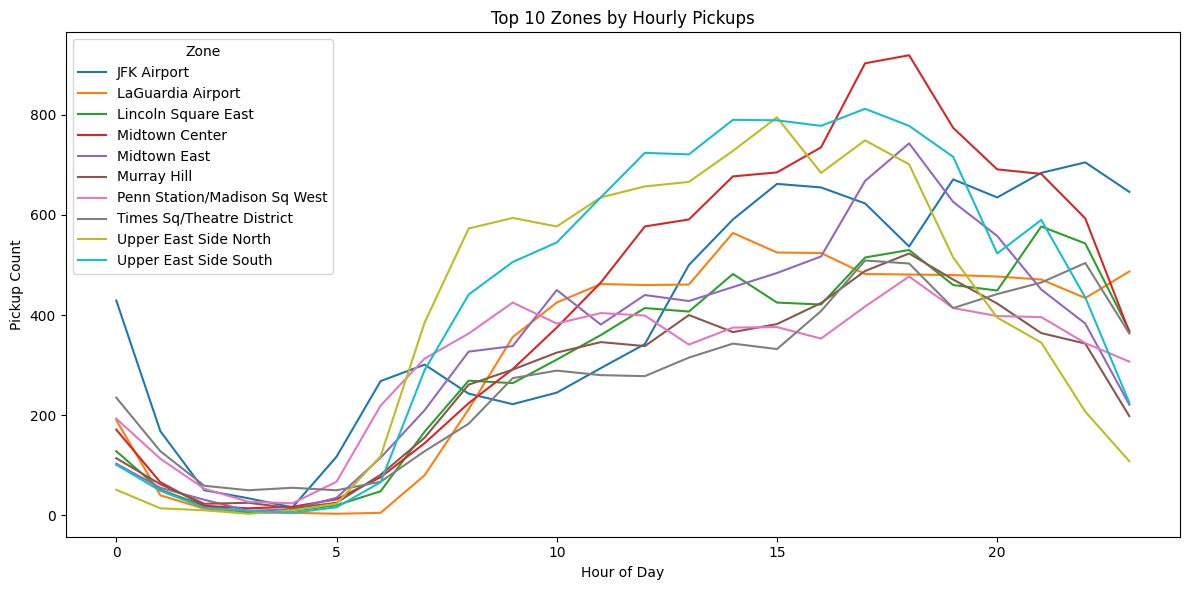

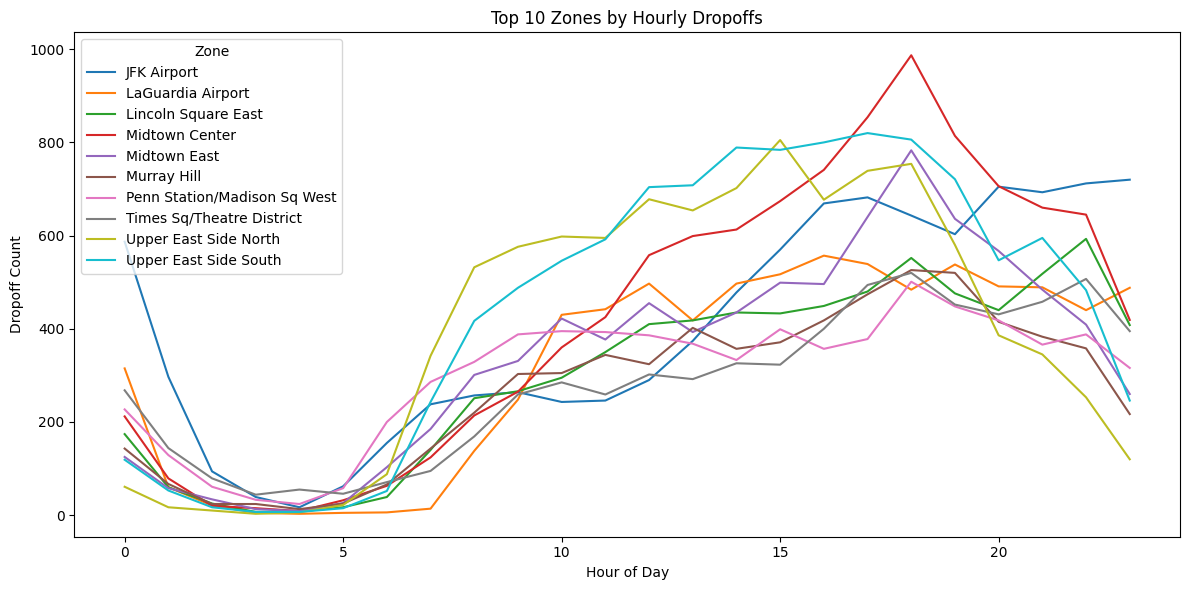

In [95]:
# Find top 10 pickup and dropoff zones
pickup_hourly = df4.groupby(['zone', 'hour']).size().reset_index(name='pickup_count')
df4['dropoff_hour'] = df4['tpep_dropoff_datetime'].dt.hour
dropoff_hourly = df4.groupby(['zone', 'dropoff_hour']).size().reset_index(name='dropoff_count')
top_pu_zones = pickup_hourly.groupby('zone')['pickup_count'].sum().nlargest(10).index
pickup_hourly_top = pickup_hourly[pickup_hourly['zone'].isin(top_pu_zones)]
top_do_zones = dropoff_hourly.groupby('zone')['dropoff_count'].sum().nlargest(10).index
dropoff_hourly_top = dropoff_hourly[dropoff_hourly['zone'].isin(top_do_zones)]

# Plot: Top 10 Pickup Zones
plt.figure(figsize=(12, 6))
sns.lineplot(data=pickup_hourly_top, x='hour', y='pickup_count', hue='zone')
plt.title('Top 10 Zones by Hourly Pickups')
plt.xlabel('Hour of Day')
plt.ylabel('Pickup Count')
plt.legend(title='Zone',  loc='upper left')
plt.tight_layout()
plt.show()

# Plot: Top 10 Dropoff Zones
plt.figure(figsize=(12, 6))
sns.lineplot(data=dropoff_hourly_top, x='dropoff_hour', y='dropoff_count', hue='zone')
plt.title('Top 10 Zones by Hourly Dropoffs')
plt.xlabel('Hour of Day')
plt.ylabel('Dropoff Count')
plt.legend(title='Zone', loc='upper left')
plt.tight_layout()
plt.show()


Pickup Trend:
Most zones show gradual increase from morning, peaking between 15:00 to 18:00.

Midtown Center and Upper East Side South peak strongly in late afternoon.

Airports show more stable or early pickups — JFK has a high spike around midnight and early morning.

Dropoff Trend:
Similar shape to pickups but with peaks more spread out.

Midtown Center hits highest dropoffs around 17:00–18:00, likely reflecting workers or evening crowds.

Airports (JFK and LaGuardia) have early morning dropoff peaks — showing arrivals for flights.

Residential areas like Upper East Side show strong evening dropoffs, suggesting people going home.

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [96]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212223 entries, 0 to 212222
Data columns (total 35 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               212223 non-null  int64         
 1   tpep_pickup_datetime   212223 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  212223 non-null  datetime64[ns]
 3   passenger_count        212223 non-null  float64       
 4   trip_distance          212223 non-null  float64       
 5   RatecodeID             212223 non-null  float64       
 6   store_and_fwd_flag     212223 non-null  object        
 7   PULocationID           212223 non-null  int64         
 8   DOLocationID           212223 non-null  int64         
 9   payment_type           212223 non-null  int64         
 10  fare_amount            212223 non-null  float64       
 11  extra                  212223 non-null  float64       
 12  mta_tax                212223 non-null  floa

In [97]:
pickup_hourly_top

,zone,hour,pickup_count
838,JFK Airport,0,429
839,JFK Airport,1,168
840,JFK Airport,2,50
841,JFK Airport,3,34
842,JFK Airport,4,16
...,...,...,...
1795,Upper East Side South,19,716
1796,Upper East Side South,20,523
1797,Upper East Side South,21,590
1798,Upper East Side South,22,435


In [98]:
dropoff_hourly_top

,zone,dropoff_hour,dropoff_count
830,JFK Airport,0,587
831,JFK Airport,1,297
832,JFK Airport,2,94
833,JFK Airport,3,39
834,JFK Airport,4,17
...,...,...,...
1788,Upper East Side South,19,721
1789,Upper East Side South,20,547
1790,Upper East Side South,21,595
1791,Upper East Side South,22,483


In [100]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
dropoff_hourly_top_copy = dropoff_hourly_top.copy()

# Rename dropoff_hour column to hour for consistency
dropoff_hourly_top_copy.rename(columns={'dropoff_hour': 'hour'}, inplace=True)

merged_data = pd.merge(pickup_hourly_top, dropoff_hourly_top_copy,
                       on=['zone', 'hour'], how='outer').fillna(0)

merged_data['pickup_to_dropoff_ratio'] = merged_data['pickup_count'] / merged_data['dropoff_count']
top_10_ratio = merged_data.sort_values(by='pickup_to_dropoff_ratio', ascending=False).head(10)
bottom_10_ratio = merged_data.sort_values(by='pickup_to_dropoff_ratio', ascending=True).head(10)

# Display results
print("Top 10 Pickup/Dropoff Ratios:")
print(top_10_ratio[['zone', 'hour', 'pickup_to_dropoff_ratio']])
print("\nBottom 10 Pickup/Dropoff Ratios:")
print(bottom_10_ratio[['zone', 'hour', 'pickup_to_dropoff_ratio']])

Top 10 Pickup/Dropoff Ratios:
                          zone  hour  pickup_to_dropoff_ratio
31           LaGuardia Airport     7                 5.714286
76              Midtown Center     4                 1.888889
5                  JFK Airport     5                 1.887097
6                  JFK Airport     6                 1.729032
28           LaGuardia Airport     4                 1.666667
196      Upper East Side North     4                 1.666667
32           LaGuardia Airport     8                 1.536232
33           LaGuardia Airport     9                 1.435484
175  Times Sq/Theatre District     7                 1.347368
101               Midtown East     5                 1.346154

Bottom 10 Pickup/Dropoff Ratios:
                      zone  hour  pickup_to_dropoff_ratio
2              JFK Airport     2                 0.531915
1              JFK Airport     1                 0.565657
29       LaGuardia Airport     5                 0.600000
24       LaGuardia Air

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [101]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones
pickup_night = df4[(df4['hour'] >= 23) | (df4['hour'] <= 5)]
pickup_night_grouped = pickup_night.groupby(['zone', 'hour']).size().reset_index(name='pickup_count')
dropoff_night = df4[(df4['dropoff_hour'] >= 23) | (df4['dropoff_hour'] <= 5)]
dropoff_night_grouped = dropoff_night.groupby(['zone', 'dropoff_hour']).size().reset_index(name='dropoff_count')
# Top 10 pickup zones during night hours
top_pickup_night_zones = pickup_night_grouped.groupby('zone')['pickup_count'].sum().nlargest(10).index
pickup_zones_list = top_pickup_night_zones.tolist()

# Top 10 dropoff zones during night hours
top_dropoff_night_zones = dropoff_night_grouped.groupby('zone')['dropoff_count'].sum().nlargest(10).index
dropoff_zones_list = top_dropoff_night_zones.tolist()

print("zones with high pickup raffic during night hours (11PM to 5AM):",pickup_zones_list)
print("zones with high dropoff raffic during night hours (11PM to 5AM):", dropoff_zones_list)

zones with high pickup raffic during night hours (11PM to 5AM): ['East Village', 'West Village', 'JFK Airport', 'Lower East Side', 'Clinton East', 'Greenwich Village South', 'Times Sq/Theatre District', 'Penn Station/Madison Sq West', 'LaGuardia Airport', 'Gramercy']
zones with high dropoff raffic during night hours (11PM to 5AM): ['East Village', 'JFK Airport', 'West Village', 'Lower East Side', 'Clinton East', 'Greenwich Village South', 'Times Sq/Theatre District', 'LaGuardia Airport', 'Penn Station/Madison Sq West', 'Midtown Center']


Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [102]:
# Filter for night hours (11 PM to 5 AM)
#Here assuming hours related pickup time!!

night_hours = list(range(23, 24)) + list(range(0, 6))  # 11PM to 5AM
day_hours = list(range(6, 23))  # 6AM to 10PM

total_revenue = df4['total_amount'].sum()

# Nighttime revenue
night_revenue = df4[df4['hour'].isin(night_hours)]['total_amount'].sum()

# Daytime revenue
day_revenue = df4[df4['hour'].isin(day_hours)]['total_amount'].sum()

# Revenue shares
night_share = night_revenue / total_revenue
day_share = day_revenue / total_revenue

# Print results
print(f"Nighttime Revenue Share (11PM–5AM): {night_share:.2%}")
print(f"Daytime Revenue Share (6AM–10PM): {day_share:.2%}")



Nighttime Revenue Share (11PM–5AM): 12.00%
Daytime Revenue Share (6AM–10PM): 88.00%


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

Average fare per mile per passenger by passenger count:
   passenger_count  fare_per_mile_per_passenger
0              1.0                    14.839842
1              2.0                     8.647112
2              3.0                     5.660458
3              4.0                     5.228880
4              5.0                     2.569123
5              6.0                     2.157119


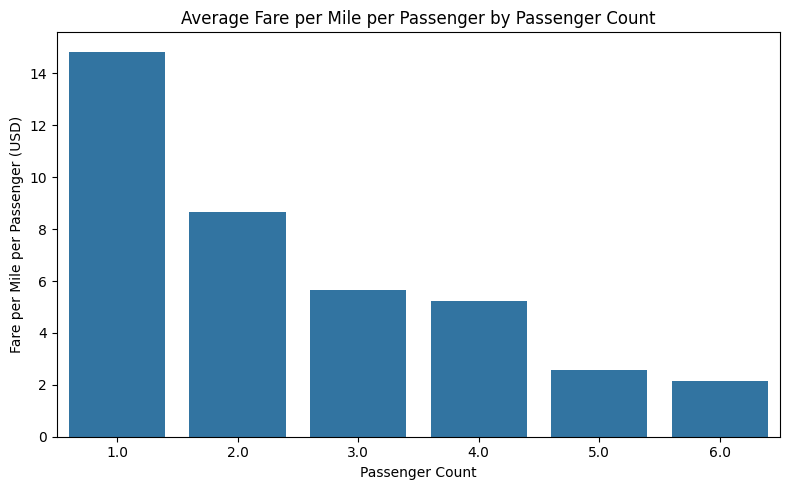

In [168]:
# Analyse the fare per mile per passenger for different passenger counts

# Filter out invalid records (zero distance or zero passengers)
trip_passenger = df4[(df4['trip_distance'] > 0) & (df4['passenger_count'] > 0)]
trip_passenger = trip_passenger.copy()
trip_passenger['fare_per_mile_per_passenger'] = trip_passenger['total_amount'] / (trip_passenger['trip_distance'] * trip_passenger['passenger_count'])

# Group by passenger count and compute the average
Avg_fare_per_mile_passenger = trip_passenger.groupby('passenger_count')['fare_per_mile_per_passenger'].mean().reset_index()

# Sort for better readability
Avg_fare_per_mile_passenger = Avg_fare_per_mile_passenger.sort_values('passenger_count')

# Display result
print("Average fare per mile per passenger by passenger count:")
print(Avg_fare_per_mile_passenger)
plt.figure(figsize=(8, 5))
sns.barplot(data=Avg_fare_per_mile_passenger, x='passenger_count', y='fare_per_mile_per_passenger')

plt.title('Average Fare per Mile per Passenger by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare per Mile per Passenger (USD)')
plt.xticks(ticks=range(len(Avg_fare_per_mile_passenger)), labels=Avg_fare_per_mile_passenger['passenger_count'])
plt.tight_layout()
plt.show()


Solo riders pay the most per mile per person — nearly 7x more than a group of 6.

As passenger count increases, the cost per person drops sharply.

The biggest savings happen when going from 1 to 2 passengers, and again from 2 to 3+.

For groups of 5 or 6, the fare is split efficiently, costing just 2–2.5 per mile per person.

**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

In [169]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212223 entries, 0 to 212222
Data columns (total 36 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               212223 non-null  int64         
 1   tpep_pickup_datetime   212223 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  212223 non-null  datetime64[ns]
 3   passenger_count        212223 non-null  float64       
 4   trip_distance          212223 non-null  float64       
 5   RatecodeID             212223 non-null  float64       
 6   store_and_fwd_flag     212223 non-null  object        
 7   PULocationID           212223 non-null  int64         
 8   DOLocationID           212223 non-null  int64         
 9   payment_type           212223 non-null  int64         
 10  fare_amount            212223 non-null  float64       
 11  extra                  212223 non-null  float64       
 12  mta_tax                212223 non-null  floa

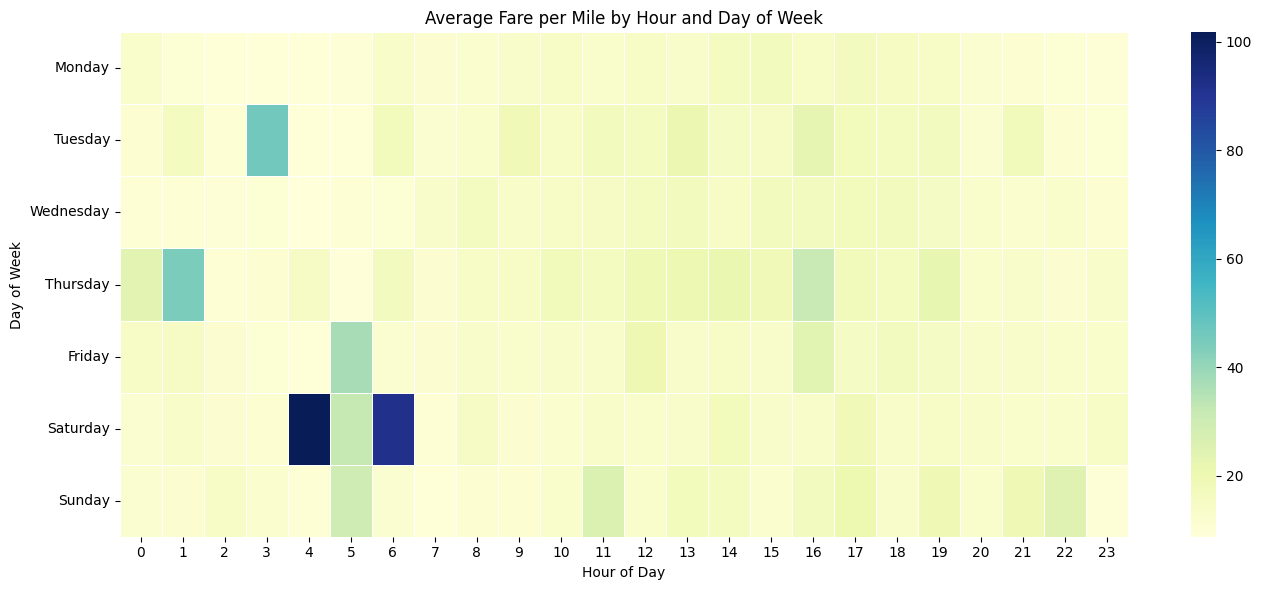

In [174]:
# Compare the average fare per mile for different days and for different times of the day
valid_trips = df4[(df4['trip_distance'] > 0) & (df4['total_amount'] > 0)].copy()
valid_trips['fare_per_mile'] = valid_trips['total_amount'] / valid_trips['trip_distance']

valid_trips['day_of_week'] = valid_trips['tpep_pickup_datetime'].dt.day_name()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_data = valid_trips.pivot_table(index='day_of_week', columns='hour', values='fare_per_mile', aggfunc='mean')
pivot_data = pivot_data.reindex(weekday_order)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_data, cmap='YlGnBu', annot=False, linewidths=0.5)
plt.title('Average Fare per Mile by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()


Fare per mile is higher late at night and early morning, especially on weekends.

These high values are often due to short trips where base fare dominates, or night surcharges.

During the day, pricing is more predictable — possibly due to regular commuting and longer business-related trips.

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

Average fare per mile by Vendor and Hour of Day:
    VendorID  hour  fare_per_mile
0          1     0      11.100041
1          1     1      11.587765
2          1     2      11.492543
3          1     3      11.515488
4          1     4      11.093134
5          1     5      11.671836
6          1     6      10.784033
7          1     7      11.627802
8          1     8      13.045863
9          1     9      13.355676
10         1    10      13.215016
11         1    11      13.843635
12         1    12      14.185209
13         1    13      13.487404
14         1    14      14.161686
15         1    15      13.965597
16         1    16      15.452480
17         1    17      15.209459
18         1    18      15.328079
19         1    19      14.546444
20         1    20      12.578764
21         1    21      12.366570
22         1    22      11.868701
23         1    23      11.261712
24         2     0      14.012773
25         2     1      16.283971
26         2     2      12.624263

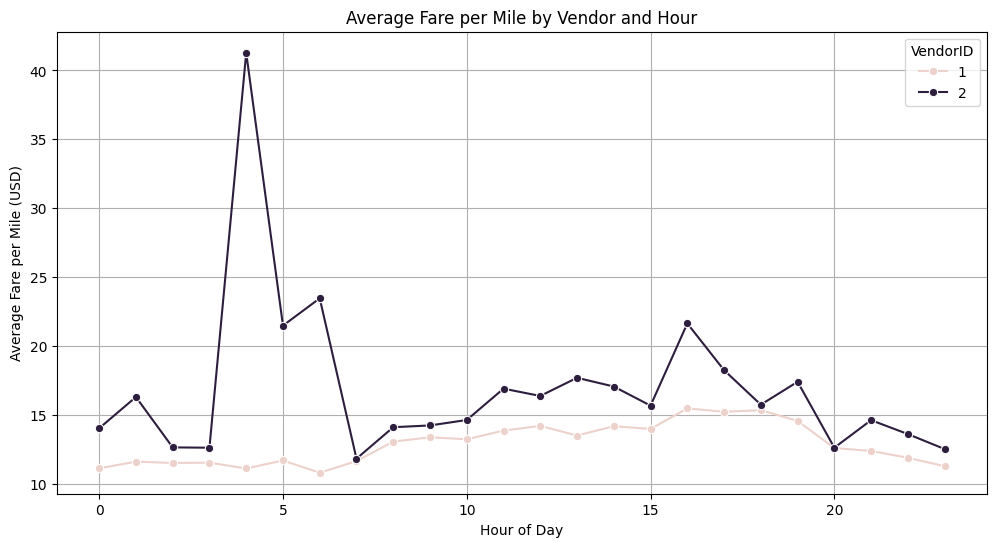

In [175]:
# Compare fare per mile for different vendors

valid_trips = df4[df4['trip_distance'] > 0].copy()
valid_trips['fare_per_mile'] = valid_trips['total_amount'] / valid_trips['trip_distance']
# Group by vendor and hour, calculate average fare per mile
vendor_hourly_fare = valid_trips.groupby(['VendorID', 'hour'])['fare_per_mile'].mean().reset_index()

# Sort the result for readability
vendor_hourly_fare = vendor_hourly_fare.sort_values(['VendorID', 'hour'])

# Display result
print("Average fare per mile by Vendor and Hour of Day:")
print(vendor_hourly_fare)

plt.figure(figsize=(12, 6))
sns.lineplot(data=vendor_hourly_fare, x='hour', y='fare_per_mile', hue='VendorID', marker='o')
plt.title('Average Fare per Mile by Vendor and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare per Mile (USD)')
plt.grid(True)
plt.show()



Vendor 1 has a steady, consistent pricing model, slightly increasing during high-demand hours.
Vendor 2 charges significantly higher fares per mile, especially in early morning and afternoon. These may be caused by:
•	Short-distance trips inflating fare-per-mile
•	Surcharge patterns
•	Small sample sizes during odd hours


**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


   VendorID distance_tier  fare_per_mile
0         1     0-2 miles       9.400379
3         2     0-2 miles      13.482784
1         1     2-5 miles       6.357415
4         2     2-5 miles       6.540588
2         1      >5 miles       4.452229
5         2      >5 miles       4.503982


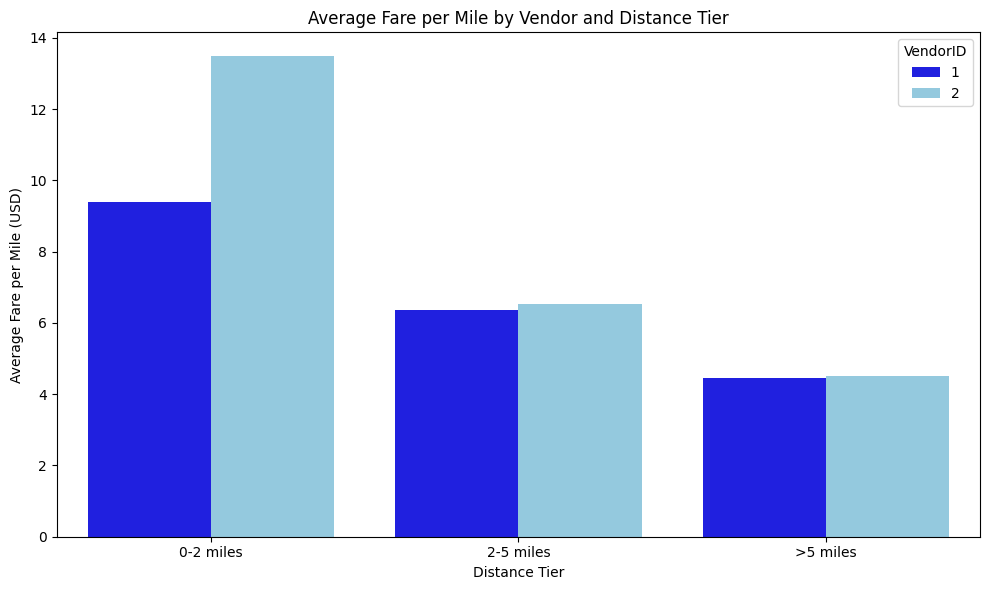

In [106]:
# Defining distance tiers
def distance_tier(dist):
    if dist <= 2:
        return '0-2 miles'
    elif dist <= 5:
        return '2-5 miles'
    else:
        return '>5 miles'
valid_trips['distance_tier'] = valid_trips['trip_distance'].apply(distance_tier)
valid_trips['fare_per_mile'] = valid_trips['fare_amount'] / valid_trips['trip_distance']
tiered_fare = (
    valid_trips.groupby(['VendorID', 'distance_tier'])['fare_per_mile']
    .mean()
    .reset_index()
    .sort_values(['distance_tier', 'VendorID'])
)
print(tiered_fare)
plt.figure(figsize=(10, 6))
palette = {1: 'blue', 2: 'skyblue'}
sns.barplot(data=tiered_fare, x='distance_tier', y='fare_per_mile', hue='VendorID', palette=palette)

plt.title('Average Fare per Mile by Vendor and Distance Tier')
plt.xlabel('Distance Tier')
plt.ylabel('Average Fare per Mile (USD)')
plt.legend(title='VendorID')
plt.tight_layout()
plt.show()


Short rides are where the biggest pricing difference exists.

Vendor 2 seems to charge more aggressively for short distances.

Longer trips normalize fare rates, suggesting base fares have less impact when distance is high.

This analysis can help passengers and regulators:

Passengers may prefer Vendor 1 for short trips.

Fleet managers or policymakers may monitor Vendor 2 is short-trip pricing behavior.

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

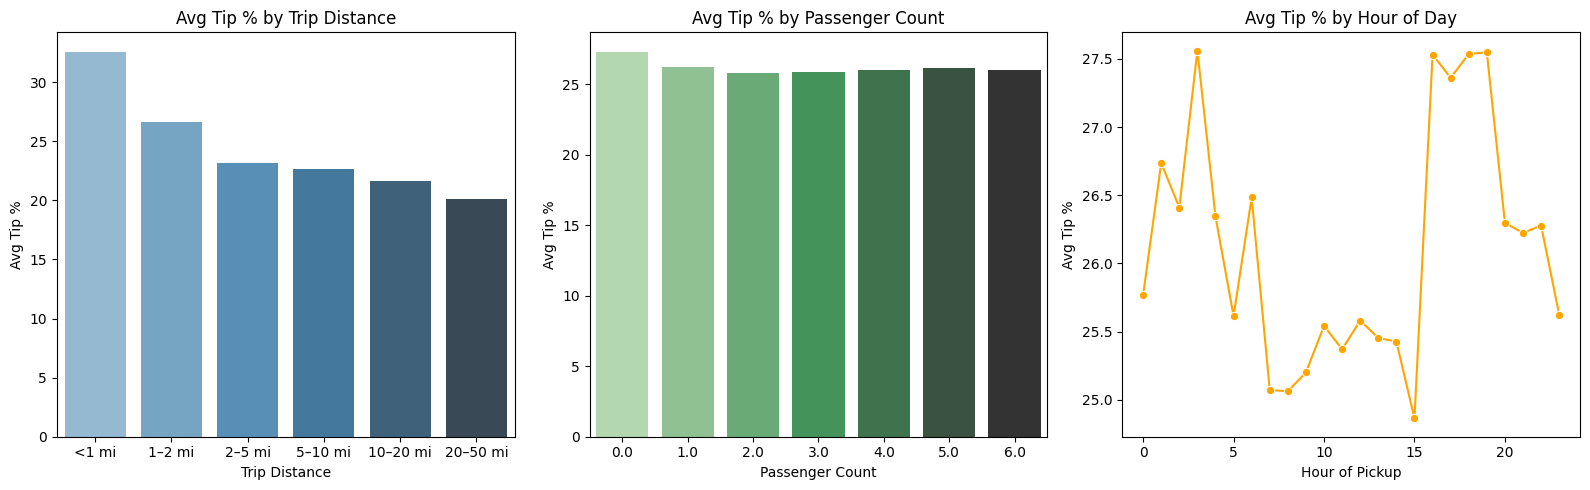

In [107]:
#  Analyze tip percentages based on distances, passenger counts and pickup times

# Filter valid records
df_tip = df4[(df4['fare_amount'] > 0) & (df4['tip_amount'] >= 0)]

# Calculate tip percentage
df_tip['tip_percent'] = (df_tip['tip_amount'] / df_tip['fare_amount']) * 100

#Tip % vs Trip Distance (binned)
df_tip['distance_bin'] = pd.cut(df_tip['trip_distance'],
                                 bins=[0, 1, 2, 5, 10, 20, 50],
                                 labels=['<1 mi', '1–2 mi', '2–5 mi', '5–10 mi', '10–20 mi', '20–50 mi'])

distance_tip = df_tip.groupby('distance_bin', observed=True)['tip_percent'].mean().reset_index()

# Tip % vs Passenger Count
passenger_tip = df_tip.groupby('passenger_count')['tip_percent'].mean().reset_index()

#Tip % vs Hour of Pickup
df_tip['pickup_hour'] = pd.to_datetime(df_tip['tpep_pickup_datetime']).dt.hour
hour_tip = df_tip.groupby('pickup_hour')['tip_percent'].mean().reset_index()

plt.figure(figsize=(16, 5))

# Tip vs Distance
plt.subplot(1, 3, 1)
sns.barplot(data=distance_tip, x='distance_bin', y='tip_percent', hue='distance_bin', palette='Blues_d', legend=False)
plt.title('Avg Tip % by Trip Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Avg Tip %')

# Tip vs Passenger Count
plt.subplot(1, 3, 2)
sns.barplot(data=passenger_tip, x='passenger_count', y='tip_percent', hue='passenger_count', palette='Greens_d', legend=False)
plt.title('Avg Tip % by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Avg Tip %')

# Tip vs Pickup Hour
plt.subplot(1, 3, 3)
sns.lineplot(data=hour_tip, x='pickup_hour', y='tip_percent', marker='o', color='orange')
plt.title('Avg Tip % by Hour of Day')
plt.xlabel('Hour of Pickup')
plt.ylabel('Avg Tip %')

plt.tight_layout()
plt.show()


Short trips (<1 mile) receive the highest tip percentage (around 32%).
Tip percentages remain very stable (around 26 to 27%) regardless of how many passengers
Tip % gradually declines as trip distance increases:

1 to 2 miles  are around   27%

5 to 10 miles  are around   23%

20 to 50 miles  are around   20% are on board.
Slight dip for 0 passengers, which might represent errors or no-tips cases (e.g., test rides or airport vouchers).
Tips hover around 25 to 27.5%, with a few small peaks:

Around 2 AM and 18 to 20 PM show slightly higher tipping.

Lowest tipping happens around 15:00 (3 PM) and early morning (8 AM).

Additional analysis [optional]: Let's try comparing cases of low tips with

*   List item
*   List item

cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

Comparison of low-tip vs high-tip trips:                  Average Trip Distance  Average Fare Amount  \
Low Tip (<10%)                    4.89                26.19   
High Tip (>25%)                   2.30                14.38   

                 Average Passenger Count  Average Tip %  Average Pickup Hour  
Low Tip (<10%)                      1.36           6.73                14.06  
High Tip (>25%)                     1.35          32.21                14.62  


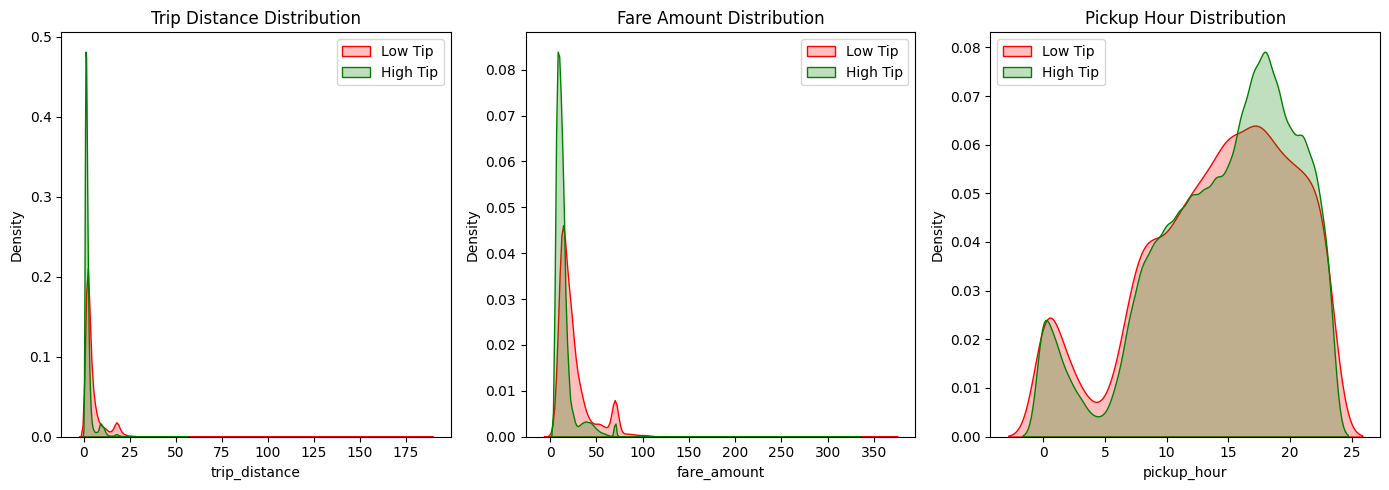

In [108]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%
low_tip = df_tip[df_tip['tip_percent'] < 10].copy()
high_tip = df_tip[df_tip['tip_percent'] > 25].copy()
compare_df = pd.DataFrame({
    'Average Trip Distance': [low_tip['trip_distance'].mean(), high_tip['trip_distance'].mean()],
    'Average Fare Amount': [low_tip['fare_amount'].mean(), high_tip['fare_amount'].mean()],
    'Average Passenger Count': [low_tip['passenger_count'].mean(), high_tip['passenger_count'].mean()],
    'Average Tip %': [low_tip['tip_percent'].mean(), high_tip['tip_percent'].mean()],
    'Average Pickup Hour': [low_tip['pickup_hour'].mean(), high_tip['pickup_hour'].mean()]
}, index=['Low Tip (<10%)', 'High Tip (>25%)'])
print("Comparison of low-tip vs high-tip trips:",compare_df.round(2))
plt.figure(figsize=(14, 5))

# Distance
plt.subplot(1, 3, 1)
sns.kdeplot(low_tip['trip_distance'], label='Low Tip', fill=True, color='red')
sns.kdeplot(high_tip['trip_distance'], label='High Tip', fill=True, color='green')
plt.title('Trip Distance Distribution')
plt.legend()

# Fare Amount
plt.subplot(1, 3, 2)
sns.kdeplot(low_tip['fare_amount'], label='Low Tip', fill=True, color='red')
sns.kdeplot(high_tip['fare_amount'], label='High Tip', fill=True, color='green')
plt.title('Fare Amount Distribution')
plt.legend()

# Pickup Hour
plt.subplot(1, 3, 3)
sns.kdeplot(low_tip['pickup_hour'], label='Low Tip', fill=True, color='red')
sns.kdeplot(high_tip['pickup_hour'], label='High Tip', fill=True, color='green')
plt.title('Pickup Hour Distribution')
plt.legend()

plt.tight_layout()
plt.show()



Shorter, cheaper trips tend to earn better tips — possibly because they feel faster, smoother, and more personal.

Longer trips get worse tip percentages, even though they generate more revenue.

Tipping behavior is more emotional than logical — not tied to fare or passenger count, but possibly to ride experience or convenience

In [113]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212223 entries, 0 to 212222
Data columns (total 35 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               212223 non-null  int64         
 1   tpep_pickup_datetime   212223 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  212223 non-null  datetime64[ns]
 3   passenger_count        212223 non-null  float64       
 4   trip_distance          212223 non-null  float64       
 5   RatecodeID             212223 non-null  float64       
 6   store_and_fwd_flag     212223 non-null  object        
 7   PULocationID           212223 non-null  int64         
 8   DOLocationID           212223 non-null  int64         
 9   payment_type           212223 non-null  int64         
 10  fare_amount            212223 non-null  float64       
 11  extra                  212223 non-null  float64       
 12  mta_tax                212223 non-null  floa

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

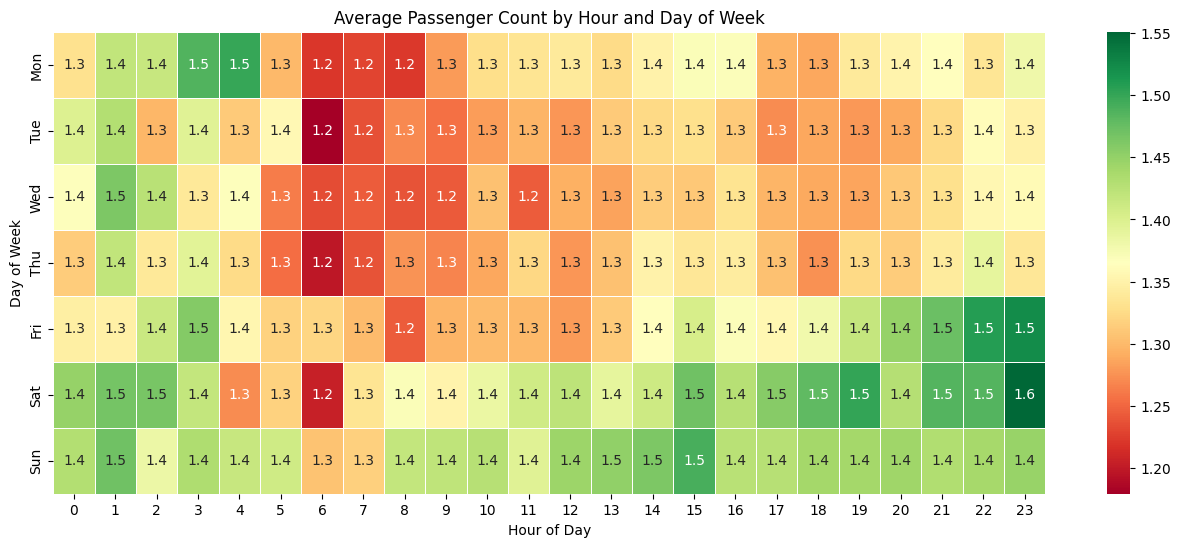

In [122]:
# See how passenger count varies across hours and days
day_name_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df4['Pickupday_name'] = df4['day_of_week'].map(day_name_map)
pivot_passenger = df4.pivot_table(
    index='Pickupday_name',
    columns='hour',
    values='passenger_count',
    aggfunc='mean'
).reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.figure(figsize=(16, 6))
sns.heatmap(pivot_passenger, cmap='RdYlGn', annot=True, fmt=".1f", linewidths=0.5)
plt.title('Average Passenger Count by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


Saturday late night trips tend to have more passengers, perhaps because people ride together after events.

Weekdays are dominated by solo riders, especially in the early morning hours.

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

<ipython-input-126-1086d9c67493>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=zone_passenger_avg, x='passenger_count', y='zone', palette='coolwarm')


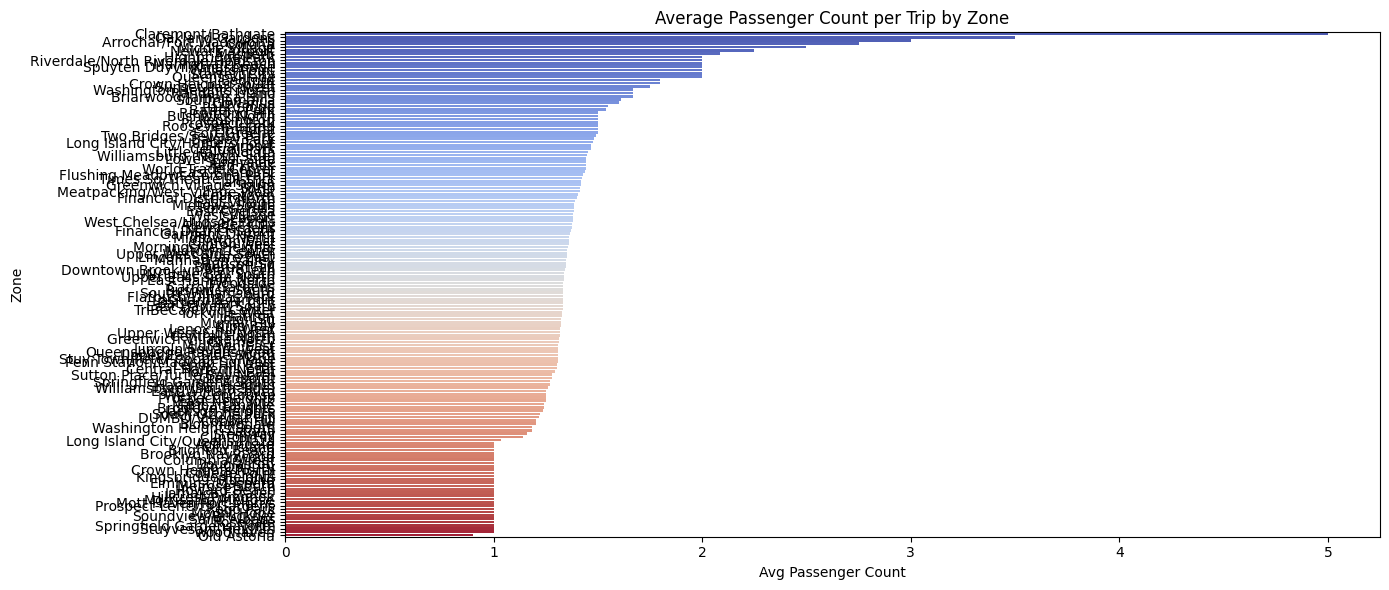

In [126]:
# How does passenger count vary across zones
zone_passenger_avg = df4.groupby('zone')['passenger_count'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(data=zone_passenger_avg, x='passenger_count', y='zone', palette='coolwarm')
plt.title('Average Passenger Count per Trip by Zone')
plt.xlabel('Avg Passenger Count')
plt.ylabel('Zone')
plt.tight_layout()
plt.show()

In [132]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.
avg_passenger_count = df4.groupby('PULocationID')['passenger_count'].mean().reset_index()
avg_passenger_count.rename(columns={'passenger_count': 'avg_passenger_count'}, inplace=True)
zones_trips = zones_trips.merge(avg_passenger_count, on='PULocationID', how='left')
zones_trips.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,trip_count,avg_passenger_count
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1.0,4.0,2.250000
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",NaN,NaN,NaN
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",NaN,NaN,NaN
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4.0,207.0,1.376812
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",NaN,NaN,NaN


Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

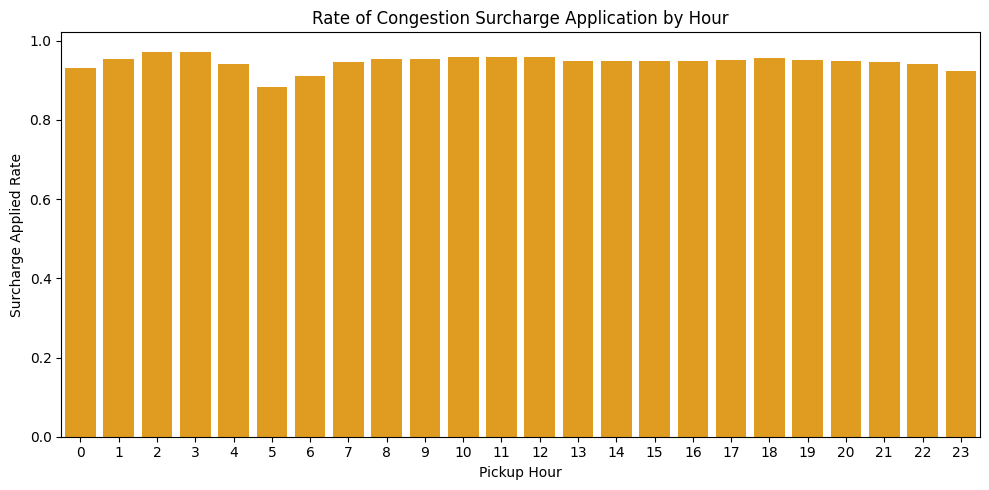

In [135]:
# How often is each surcharge applied?
surcharge_by_hour = df4.groupby('hour')['congestion_surcharge'].apply(lambda x: (x > 0).mean()).reset_index()
surcharge_by_hour.columns = ['hour', 'congestion_surcharge_rate']

plt.figure(figsize=(10, 5))
sns.barplot(data=surcharge_by_hour, x='hour', y='congestion_surcharge_rate', color='orange')
plt.title('Rate of Congestion Surcharge Application by Hour')
plt.xlabel('Pickup Hour')
plt.ylabel('Surcharge Applied Rate')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


The surcharge is applied in over 90% of trips across nearly all hours.
Peak rate is seen between 2 AM and 3 AM, possibly due to fixed surcharge zones or fewer trips concentrated in Manhattan.
5 AM shows the lowest application rate (around 88%).
A small dip also occurs at 23 PM and 6 AM, just under 90–91%.


## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**Busy Times and Days**
The busiest time of the day is in the late afternoon and early evening (3 PM – 7 PM).Thursday and Wednesday are the busiest days, while Sunday and Monday are the least busy.Most of the revenue (88%) comes during the daytime (6 AM – 10 PM). Only 12% comes at night

** Popular Pickup Zones**
The most active pickup places are:Upper East Side South
Midtown Center,JFK and LaGuardia Airports.
People often get picked up from airports in the morning and dropped off at night.

**Fare Patterns**
Fares go up as trip distance increases — longer trips cost more.But fare per mile is highest for short trips because of the minimum base fare.Vendor 2 usually charges more per mile than Vendor 1, especially for short trips.

**Tipping Behavior**
Riders give the highest tip % for short trips (<1 mile) — sometimes over 30%.
Longer trips get lower tip % (about 20%), even though the total fare is higher.
Tip % doesnot change much based on the number of passengers.
Passengers also tip a bit more during evening and late-night hours.

**Passenger Count Patterns**
Most rides have 1–2 passengers.
On weekends (especially Saturday nights), there are slightly more passengers per ride — up to 1.6 on average.
Weekday mornings are mostly solo riders, likely commuters.

**Surcharges**
The congestion surcharge is applied in over 90% of trips, at all times of the day.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

In [176]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212223 entries, 0 to 212222
Data columns (total 36 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               212223 non-null  int64         
 1   tpep_pickup_datetime   212223 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  212223 non-null  datetime64[ns]
 3   passenger_count        212223 non-null  float64       
 4   trip_distance          212223 non-null  float64       
 5   RatecodeID             212223 non-null  float64       
 6   store_and_fwd_flag     212223 non-null  object        
 7   PULocationID           212223 non-null  int64         
 8   DOLocationID           212223 non-null  int64         
 9   payment_type           212223 non-null  int64         
 10  fare_amount            212223 non-null  float64       
 11  extra                  212223 non-null  float64       
 12  mta_tax                212223 non-null  floa

**Send More Taxis During the Busiest Hours (3 to 7 PM)**
Most trips happen between 3 PM and 7 PM, especially at 6 PM (hour 18) with 15,456 trips.
Dispatch more cars during these hours to reduce wait time and missed bookings.
Also, these hours have more solo rides and higher tipping — good for driver earnings.

**Focus on Mid-Week Days (Wednesday & Thursday)**
Thursday and Wednesday are the busiest days, each with over 33,000 trips.
Add more drivers on these days compared to Monday and Sunday, which have the lowest demand.

**Airport Routing During Afternoon and Evening**
Airport pickups (from JFK & LaGuardia) are highest between 2 PM and 10 PM.
Make sure enough taxis are available near airports in this window to meet demand.

**Watch Vendor Pricing**
Vendor 2 charges more per mile than Vendor 1.
Try to balance dispatching fairly so customers aren't overcharged — especially for short trips where fare per mile is highest.

**Expect Solo Riders in the Evening**
Solo trips are highest at 6 PM, followed by 5 to 8 PM.
Plan more vehicles for individuals at these times — especially in downtown and commuter-heavy zones.

**Tipping Is Best Between 3 PM and 7 PM**
Tip percentage is highest at 3 PM to 7 PM, peaking at 3 PM.
Encourage drivers to work these hours — better chance of earning good tips.

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

**What to do**

Weekdays (especially Wednesday and Thursday)

Afternoons to evenings (3 PM to 8 PM)

Spring and Fall months (April, May, October)

**Reason**
These areas are always high in demand, especially during commute and event hours.

Great zones for solo rides, consistent tipping, and frequent pickups.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

 **Lower Fare per Mile for Very Short Trips**-Introduce a "micro-ride" flat fare or reduced per-mile pricing for trips under 2 miles.This makes pricing look fairer and encourages more short-trip demand.

 **Add Dynamic Pricing Based on Time of Day & Day of Week**-Apply slight peak-hour surcharges (e.g., +5%) to these windows.This boosts revenue without major fare hikes, and aligns with how demand naturally rises.

 **Encourage Group Rides with Passenger-Based Discounts**-Offer group fare bundles ,Promote carpooling in residential and nightlife areas to boost efficiency and total fare.

 **Reward Off-Peak and Long-Distance Trips with Discounts**-Offer 5–10% off for trips longer than 8–10 miles during quiet hours (midnight to 6 AM).This encourages use and keeps your fleet working.

 **Match Vendor 2 Smartly on Competitive Routes**-Match Vendor 2's pricing only in high-demand zones (e.g., Midtown, JFK), but keep lower base rates in low-demand zones.Helps win business in hot spots without overcharging elsewhere.

 **Use Tip Trends to Influence Driver Behavior, Not Pricing**-Keep base fares steady in tipping hours, but offer driver bonuses or shift rewards during those hour